# Instalação de bibliotecas

In [1]:
!pip install -U darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.0 MB/s eta 

# Importação de bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import DLinearModel, LinearRegressionModel, ARIMA, AutoARIMA, FFT, FourTheta
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from scipy import signal

import os
import shutil

# Definição de Constantes e Funções Auxiliares

## Definição de constantes

In [3]:
DATE_FORMAT_STRING = '%d/%m/%Y'
FIG_SIZE = (8,5)

## Anexando funções a TimeSeries

In [4]:
def TimeSeriesRatio(self):
  ratio_series = self.pd_series().div(self.pd_series().shift(1))[1:]
  ratio_dataframe = ratio_series.to_frame(name=f"{self.columns[0]}_ratio")
  ratio_time_series = TimeSeries.from_dataframe(ratio_dataframe)
  return ratio_time_series

def TimeSeriesDetrend(self):
  # Calcular o detrend dos dados da série
  detrended_data = signal.detrend(self.univariate_values())

  # Criar um novo TimeSeries com os dados detrendizados
  return TimeSeries.from_dataframe(pd.DataFrame({'Data': self.time_index, f"{self.columns[0]}_detrend": detrended_data}), time_col='Data', value_cols=f"{self.columns[0]}_detrend")

def TimeSeriesScalerFitAndInverseTransform(self, original):
    scaler = Scaler()
    scaler.fit(original)
    return scaler.inverse_transform(self)

def TimeSeriesInverseDetrend(self, original):
    detrend_target = original.detrend()
    trend_line = (original - detrend_target)
    start_time = self.start_time()
    end_time = self.end_time()
    if self.time_index[-1].to_pydatetime() > trend_line.time_index[-1].to_pydatetime():
        regressor = LinearRegressionModel(lags = 1)
        regressor.fit(trend_line)
        trend_line = trend_line.concatenate(regressor.predict(calculate_dates_diff(trend_line.end_time(), end_time, self.freq.freqstr) + 2))
    return self + trend_line[start_time:end_time]

def TimeSeriesCheckSeasonality(self, alpha = 0.05):
  for seasonality_period in range(2, len(self)):
    for max_lag in range(seasonality_period, len(self)):
      seasonality_exists, seasonality_period_l = check_seasonality(self, seasonality_period, max_lag, alpha)
      if seasonality_exists:
        return seasonality_period_l
  return False

def TimeSeriesPlotAcf(self):
  seasonality = self.check_seasonality()
  plot_acf(self, seasonality if seasonality else None, seasonality*2 if seasonality*2 > 24 else 24)
  plt.suptitle(self.columns[0] + ' - Autocorrelação')
  plt.title('Sazonalidade: {}'.format(seasonality if seasonality else '-'))
  plt.show()

def TimeSeriesFilter(self, filter = MovingAverageFilter(10)):
  series_filtered = filter.filter(self)
  series_residuals = (self-series_filtered)
  return TimeSeries.from_dataframe(pd.DataFrame({'Data': self.time_index, f"{self.columns[0]}_filtered": series_filtered.univariate_values()}), time_col='Data', value_cols=f"{self.columns[0]}_filtered"), TimeSeries.from_dataframe(pd.DataFrame({'Data': self.time_index, f"{self.columns[0]}_residuals": series_residuals.univariate_values()}), time_col='Data', value_cols=f"{self.columns[0]}_residuals")

def TimeSeriesPlotFourierAnalisys(self):
  # Calcular a Transformada de Fourier
  fourier_transform = np.fft.fft(self.univariate_values())
  frequencies = np.fft.fftfreq(len(self))  # Frequências correspondentes

    # Calcular as amplitudes das frequências
  amplitudes = np.abs(fourier_transform)
  amplitudes = amplitudes[:len(amplitudes)//2]  # Considerar apenas as frequências positivas

  # Encontrar as frequências dominantes (com as maiores amplitudes)
  indices_dominantes = np.argsort(amplitudes)[::-1]
  frequencias_dominantes = frequencies[indices_dominantes]
  amplitudes_dominantes = amplitudes[indices_dominantes]

  ciclos = []
  for freq, amp in zip(frequencias_dominantes[:], amplitudes_dominantes[:]):
    if freq * len(self) > 1 and amp/sum(amplitudes_dominantes) > 0.1:
      ciclos.append('{:.4f}'.format(freq))


  # Plotar a amplitude das frequências
  plt.figure(figsize=(10, 6))
  plt.plot(frequencies, np.abs(fourier_transform))
  plt.xlabel('Frequência')
  plt.ylabel('Amplitude')
  plt.suptitle(self.columns[0] + ' - Análise de Fourier')
  plt.title('Ciclos: ' + (', '.join(ciclos) if len(ciclos) > 0 else '-'))
  plt.show()

TimeSeries.ratio = TimeSeriesRatio
TimeSeries.detrend = TimeSeriesDetrend
TimeSeries.fit_inverse_transform = TimeSeriesScalerFitAndInverseTransform
TimeSeries.fit_inverse_detrend = TimeSeriesInverseDetrend
TimeSeries.check_seasonality = TimeSeriesCheckSeasonality
TimeSeries.plot_acf = TimeSeriesPlotAcf
TimeSeries.filter = TimeSeriesFilter
TimeSeries.plot_fourier_analisys = TimeSeriesPlotFourierAnalisys

In [58]:
class Detrend():
  def __init__(self):
    self.trend_line = None

  def fit(self, data):
    self.trend_line = (data - data.detrend())

  def transform(self, data):
    start_time = data.start_time()
    end_time = data.end_time()
    trend_line = self.trend_line
    if data.time_index[-1].to_pydatetime() > self.trend_line.time_index[-1].to_pydatetime():
        regressor = LinearRegressionModel(lags = 1)
        regressor.fit(self.trend_line)
        trend_line = self.trend_line.concatenate(regressor.predict(calculate_dates_diff(self.trend_line.end_time(), end_time, data.freq.freqstr) + 2))
    trend_line = trend_line[start_time:end_time]
    return data - trend_line

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

  def inverse_transform(self, data):
    start_time = data.start_time()
    end_time = data.end_time()
    trend_line = self.trend_line
    if data.time_index[-1].to_pydatetime() > self.trend_line.time_index[-1].to_pydatetime():
        regressor = LinearRegressionModel(lags = 1)
        regressor.fit(self.trend_line)
        trend_line = self.trend_line.concatenate(regressor.predict(calculate_dates_diff(self.trend_line.end_time(), end_time, data.freq.freqstr) + 2))
    trend_line = trend_line[start_time:end_time]
    return data + trend_line

## Definição de Funções

In [6]:
def plot_trend_line(series, title = None):
  plt.figure(figsize=FIG_SIZE)
  if title:
    plt.title(title)
  series.plot()
  (series - series.detrend()).plot(label = 'trend line')
  plt.show()

In [7]:
def plot_series(series, title = None):
  plt.figure(figsize=FIG_SIZE)
  if title:
    plt.title(title)
  if type(series) == TimeSeries:
    series.plot()
  elif type(series) == list:
    for serie in series:
      serie.plot()
  plt.show()

In [8]:
#squared_log_error
def sle(y_true, y_pred):
    y_true_num = []
    y_pred_num = []

    for i in y_true.values():
        if math.isnan(i) == False:
            y_true_num.append(float(i))

    for i in y_pred.values():
        if math.isnan(i) == False:
            y_pred_num.append(float(i))

    somatorio = 0
    for i in range(0, len(y_true_num)):
        x = (y_pred_num[i]/y_true_num[i])
        somatorio += (np.log(abs(x))) ** 2
    return somatorio

In [9]:
#this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series, target_series = None, scaler = None, detrend = None, returned = [],historical = False, plot = True):
    if target_series != None:
        pred_series = model.predict(n=n, series = target_series)
    else:
        pred_series = model.predict(n=n)
    if historical:
      historical_series = model.historical_forecasts(target_series)
    else:
      historical_series = None
    if scaler != None:
        pred_series = pred_series.fit_inverse_transform(scaler)
        if historical:
          historical_series = historical_series.fit_inverse_transform(scaler)
        if target_series != None:
          target_series = target_series.fit_inverse_transform(scaler)
    if detrend != None:
        pred_series = pred_series.fit_inverse_detrend(detrend)
        if historical:
          historical_series = historical_series.fit_inverse_detrend(detrend)
        if target_series != None:
          target_series = target_series.fit_inverse_detrend(detrend)
    try:
      mape_val = mape(val_series, pred_series[:len(val_series)])
    except:
      mape_val = float('inf')
    try:
      sle_val = sle(val_series, pred_series[:len(val_series)])
    except:
      sle_val = float('inf')
    if historical:
      try:
        mape_train = mape(target_series[-len(historical_series):], historical_series)
      except:
        mape_train = float('inf')
      try:
        sle_train = sle(target_series[-len(historical_series):], historical_series)
      except:
        sle_train = float('inf')
    if plot:
        plt.figure(figsize=FIG_SIZE)
        series.plot(label='actual')
        pred_series.plot(label='forecast')
        if historical:
          historical_series.plot(label='historical')
          plt.title('MAPE: t{:.2f}%'.format(mape_train) + ' v{:.2f}%'.format(mape_val) + ' - SLE: t{:.2f}'.format(sle_train) + ' v{:.2f}'.format(sle_val))
        else:
          plt.title('MAPE: {:.2f}%'.format(mape_val) + ' - SLE: {:.2f}'.format(sle_val))
        plt.legend()
        plt.show()
    try:
      returned_f = []
      for returned_l in returned:
        if returned_l.upper() == 'MAPE_VAL':
          returned_f.append(mape_val)
        elif returned_l.upper() == 'SLE_VAL':
          returned_f.append(sle_val)
        elif returned_l.upper() == 'MAPE_TRAIN':
          returned_f.append(mape_train)
        elif returned_l.upper() == 'SLE_TRAIN':
          returned_f.append(sle_train)
        elif returned_l.upper() == 'PREDICT_VALUES':
          returned_f.append(pred_series)
        elif returned_l.upper() == 'HISTORICAL_VALUES':
          returned_f.append(historical_series)
        else:
          returned_f.append(None)
      return returned_f
    except:
      return None


In [10]:
def calculate_dates_diff(start, end, freq = 'D'):
  date_range = pd.date_range(start=start, end=end, freq=freq)
  return len(date_range)

In [11]:
def set_pl_trainer_kwargs(**kwargs):

  pl_trainer_kwargs = kwargs

  if torch.cuda.is_available():
    try:
      pl_trainer_kwargs['accelerator']
    except:
      pl_trainer_kwargs['accelerator'] = "gpu"
    try:
      pl_trainer_kwargs['devices']
    except:
      pl_trainer_kwargs['devices'] = -1
  else:
      pl_trainer_kwargs['accelerator'] = "cpu"

  if pl_trainer_kwargs['accelerator'] == "cpu":
      try:
        del pl_trainer_kwargs['devices']
      except:
        pass

  return pl_trainer_kwargs

# Criando o dataset

## Leitura da Tabela de Dados

In [14]:
try:
  from google.colab import drive
  path = './google_drive'
  drive.mount(path)
  path += '/MyDrive/Documentos/TCC/data'
  if not os.path.isdir('./data'): # vemos de este diretorio ja existe
      os.mkdir('./data') # aqui criamos a pasta caso nao exista
  shutil.copyfile(path + '/Biodiesel.xlsx', './data/Biodiesel.xlsx')
except:
  pass

Drive already mounted at ./google_drive; to attempt to forcibly remount, call drive.mount("./google_drive", force_remount=True).


In [15]:
df = pd.read_excel('./data/Biodiesel.xlsx', 'Dados')
df

Data    Norte  Nordeste  Centro-Oeste      Sul  Sudeste   Brasil
0  2022-01-03  6.58694   6.53524       6.63140  6.52017  6.42527  6.50281
1  2022-01-10  6.59247   6.54389       6.49987  6.49273  6.44492  6.49439
2  2022-01-17  6.59975   6.52692       6.63605  6.50669  6.48951  6.53165
3  2022-01-24  6.57902   6.53398       6.63996  6.48883  6.46100  6.51780
4  2022-01-31  6.71899   6.67343       6.69431  6.52320  6.50844  6.58144
..        ...      ...       ...           ...      ...      ...      ...
75 2023-06-12  3.90579   4.08883       3.93079  3.77437  3.90483  3.90413
76 2023-06-19  3.98194   4.17016       4.04384  3.86726  3.99465  3.99755
77 2023-06-26  4.01177   4.23933       3.96590  3.93171  4.02113  4.02387
78 2023-07-03  4.07002   4.27576       4.03957  3.93399  4.04811  4.05114
79 2023-07-10  4.11300   4.28855       4.00777  4.07328  4.07022  4.10179

[80 rows x 7 columns]

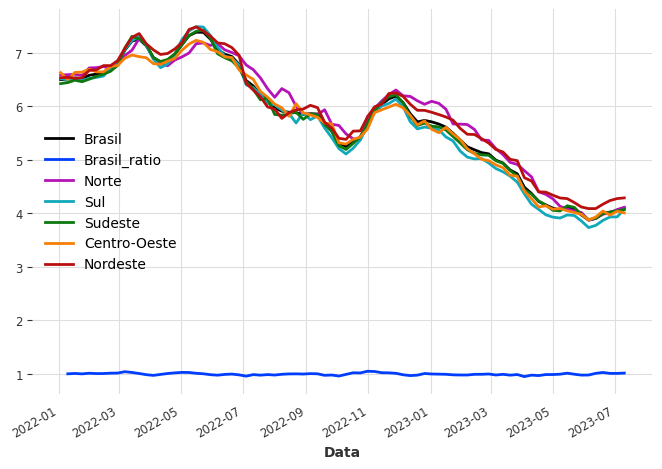

In [16]:
# Transformando o Dataframe em uma serie temporal do darts
series_national = TimeSeries.from_dataframe(df, 'Data',  'Brasil')
series_national_tx = series_national.ratio()
series_north = TimeSeries.from_dataframe(df, 'Data',  'Norte')
series_south = TimeSeries.from_dataframe(df, 'Data',  'Sul')
series_southeast = TimeSeries.from_dataframe(df, 'Data',  'Sudeste')
series_midwest = TimeSeries.from_dataframe(df, 'Data',  'Centro-Oeste')
series_northeast = TimeSeries.from_dataframe(df, 'Data',  'Nordeste')

plot_series([
    series_national,
    series_national_tx,
    series_north,
    series_south,
    series_southeast,
    series_midwest,
    series_northeast
])

## Tratamento dos dados - Série Original

### Visualização dos dados

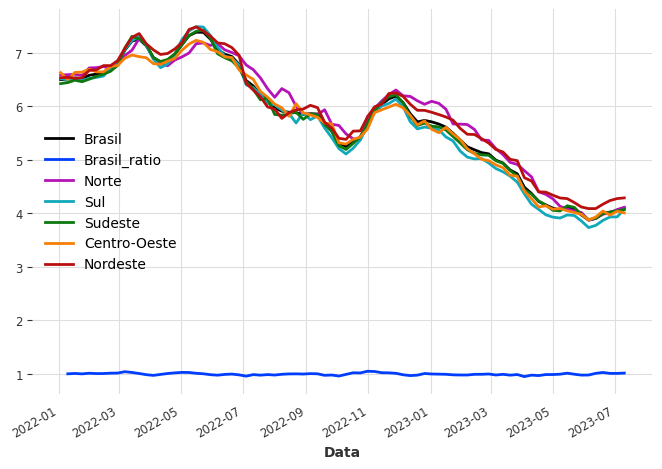

In [17]:
plot_series([
    series_national,
    series_national_tx,
    series_north,
    series_south,
    series_southeast,
    series_midwest,
    series_northeast
])

#### Verificação da Sazonalidade

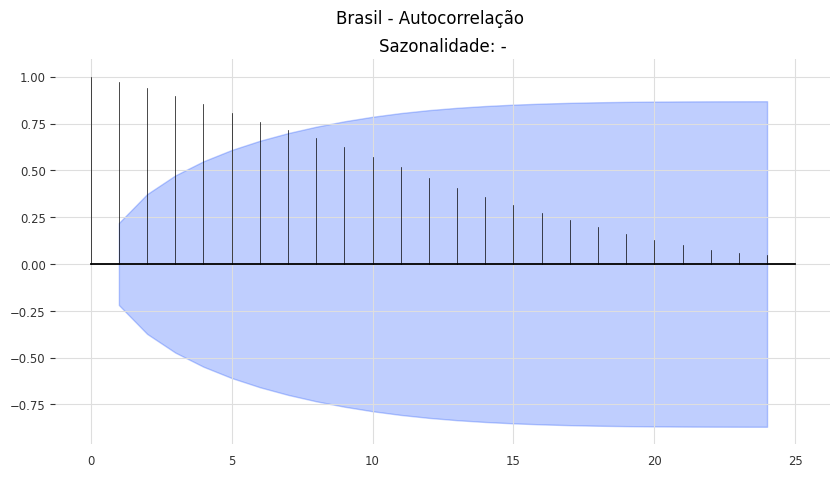

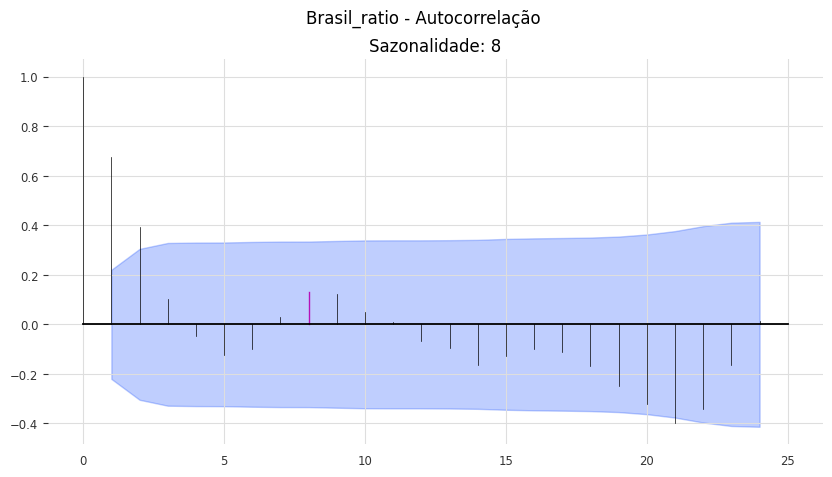

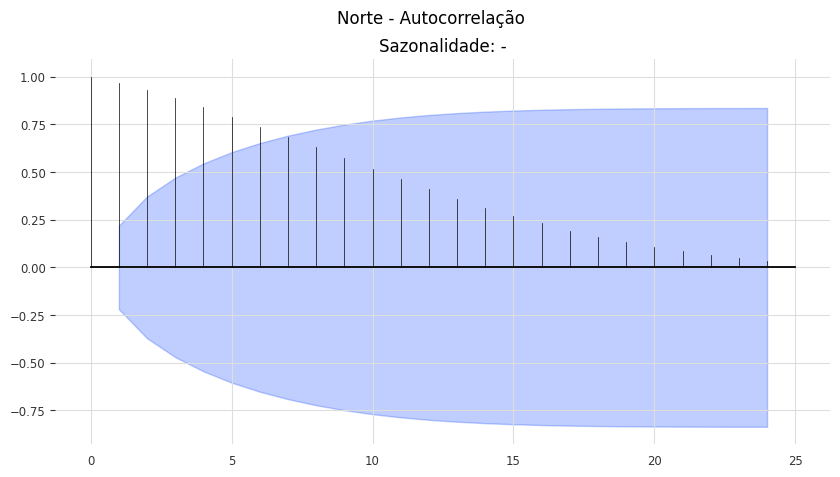

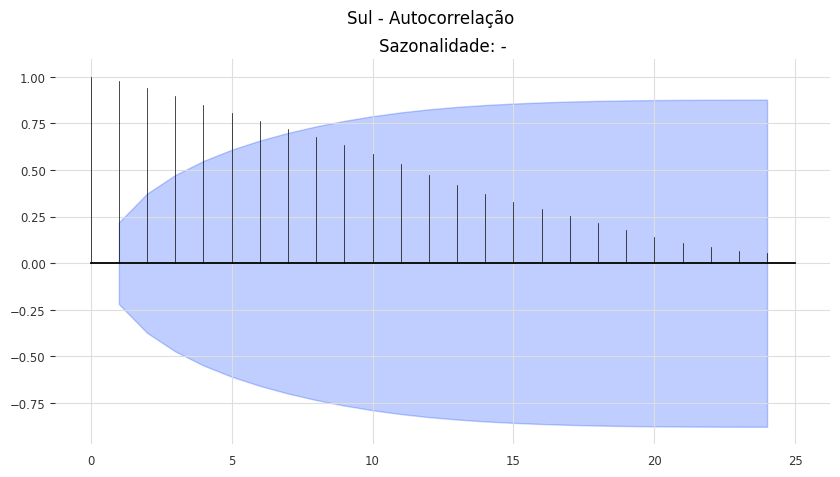

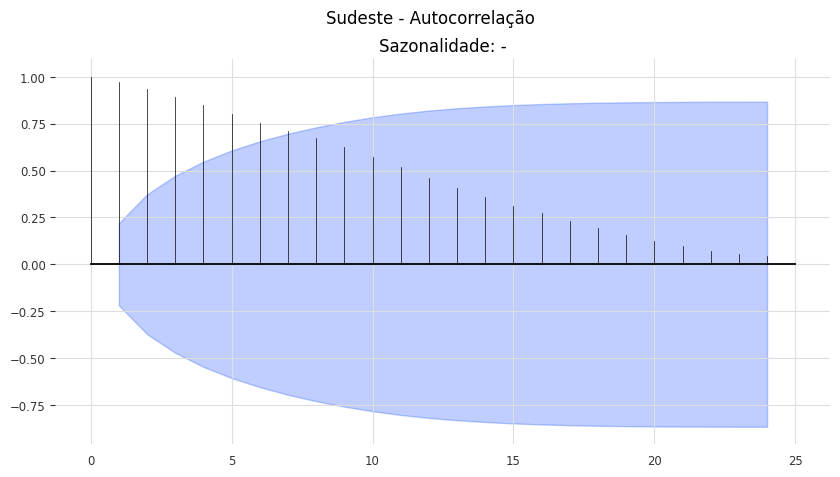

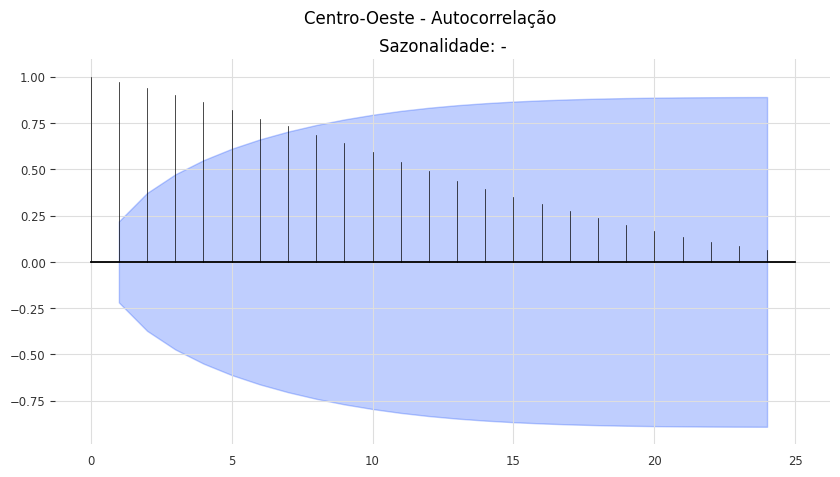

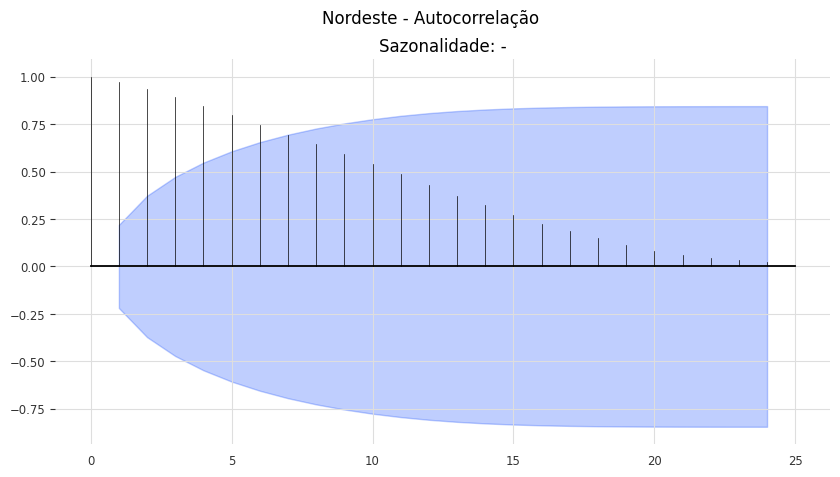

In [18]:
series_national.plot_acf()
series_national_tx.plot_acf()
series_north.plot_acf()
series_south.plot_acf()
series_southeast.plot_acf()
series_midwest.plot_acf()
series_northeast.plot_acf()

#### Verificação de Ciclos

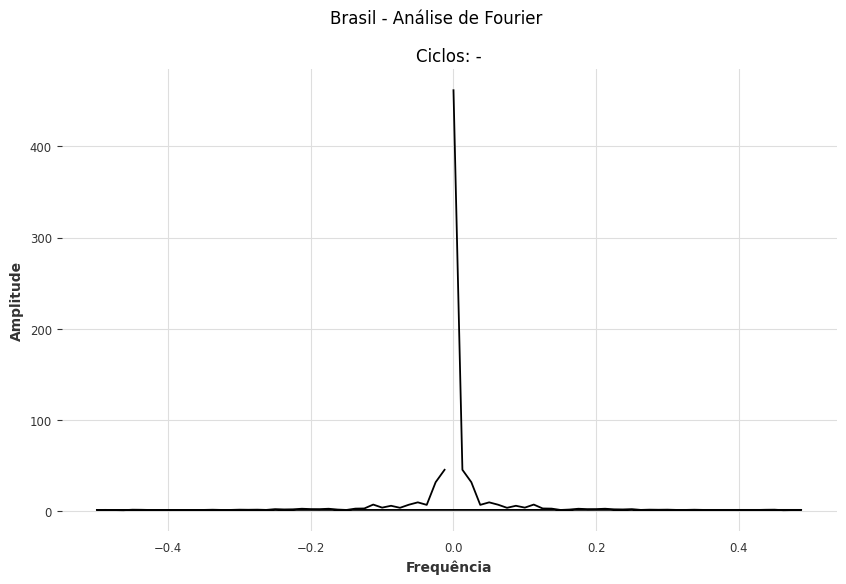

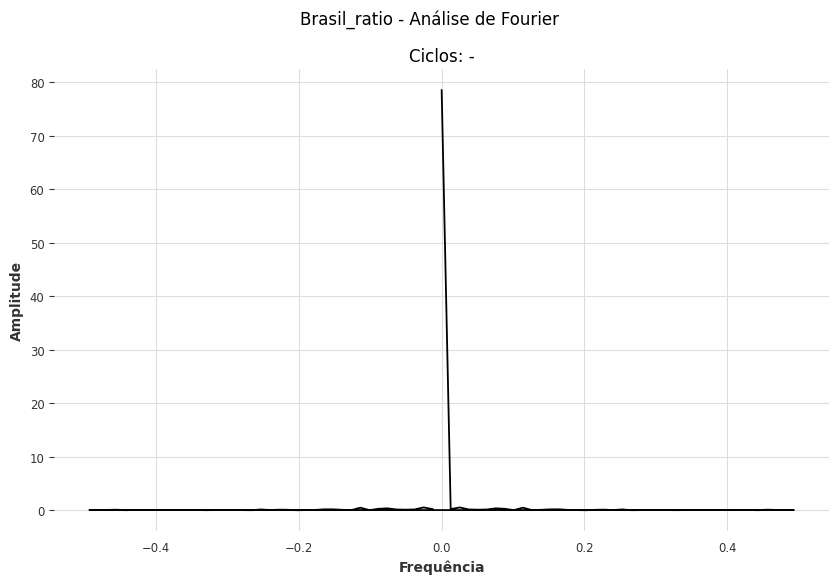

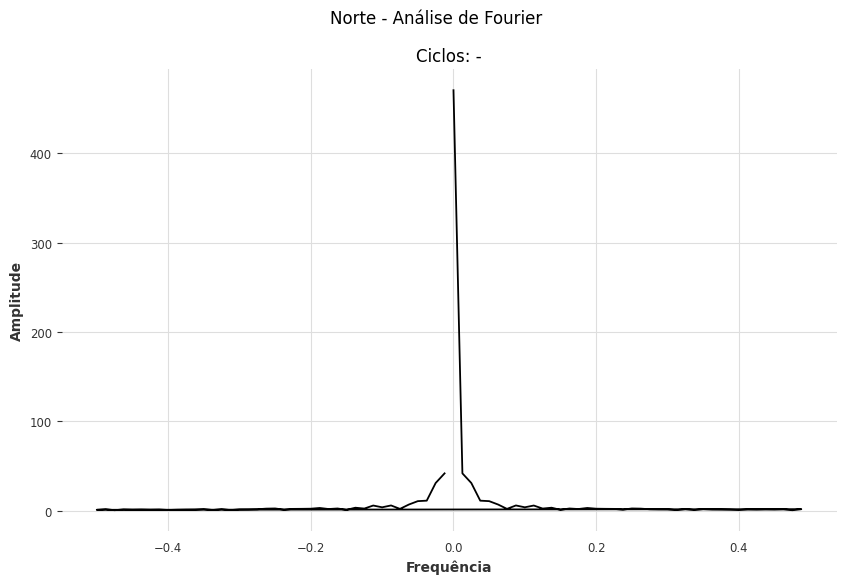

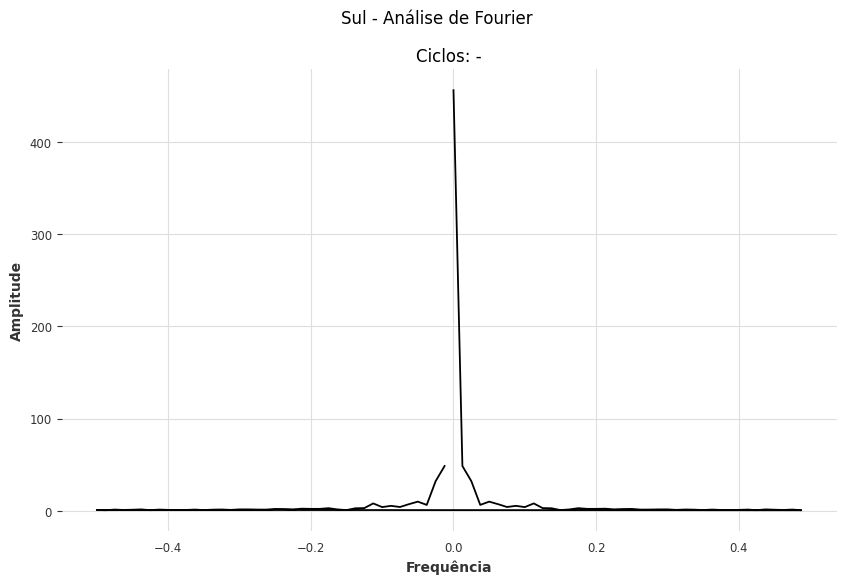

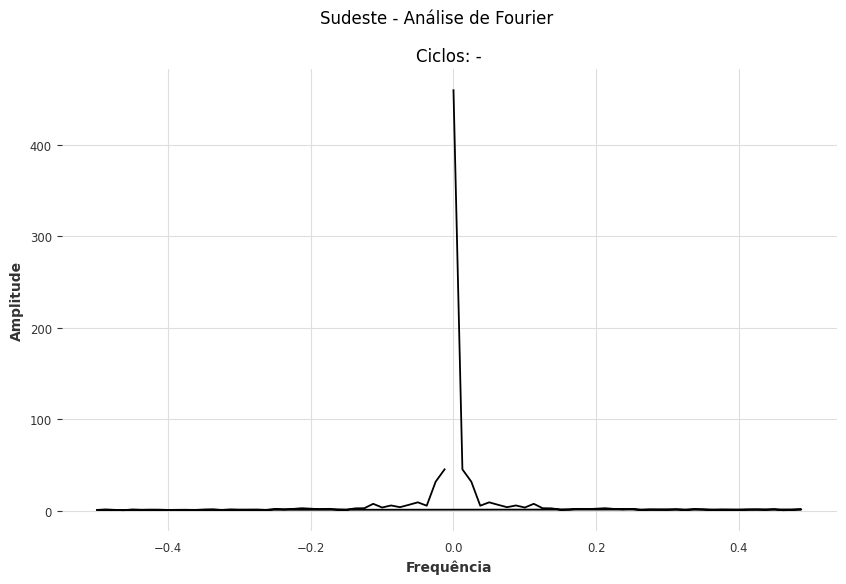

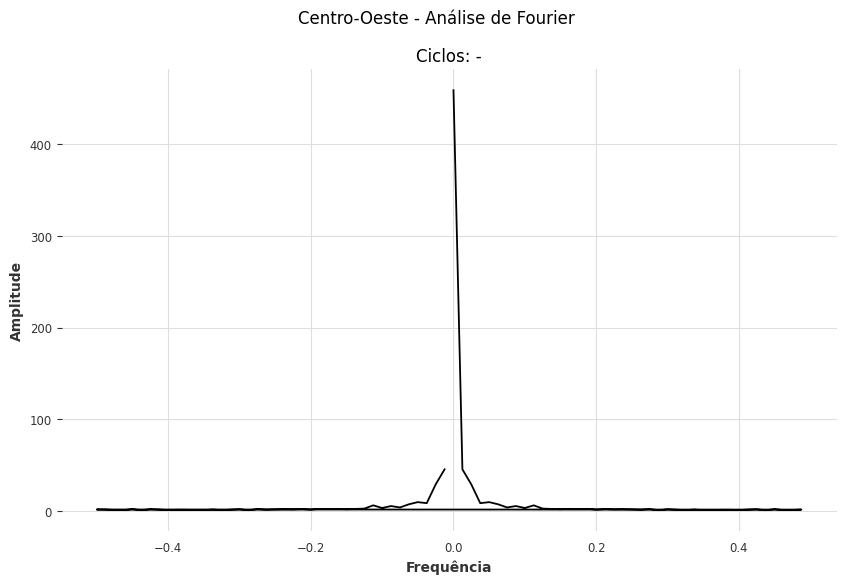

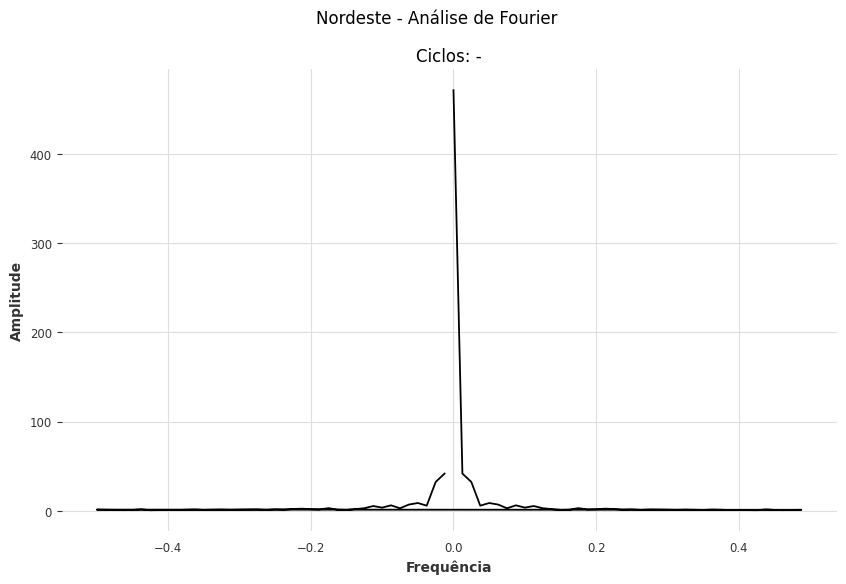

In [19]:
series_national.plot_fourier_analisys()
series_national_tx.plot_fourier_analisys()
series_north.plot_fourier_analisys()
series_south.plot_fourier_analisys()
series_southeast.plot_fourier_analisys()
series_midwest.plot_fourier_analisys()
series_northeast.plot_fourier_analisys()

### Divisão dos Conjuntos de Treino e Validação

In [20]:
train_size_percent = 70
train_size = int(len(series_national) * train_size_percent/100)
split_date = series_national.time_index[train_size].strftime('%Y%m%d')
print(f"Treinamento: {series_national.time_index[0].strftime(DATE_FORMAT_STRING)} - {series_national.time_index[train_size - 1].strftime(DATE_FORMAT_STRING)}")
print(f"Validação  : {series_national.time_index[train_size].strftime(DATE_FORMAT_STRING)} - {series_national.time_index[-1].strftime(DATE_FORMAT_STRING)}")

train_tx, val_tx = series_national_tx.split_before(pd.Timestamp(split_date))
train, val = series_national.split_before(pd.Timestamp(split_date))
train_north, val_north = series_north.split_before(pd.Timestamp(split_date))
train_south, val_south = series_south.split_before(pd.Timestamp(split_date))
train_southeast, val_southeast = series_southeast.split_before(pd.Timestamp(split_date))
train_midwest, val_midwest = series_midwest.split_before(pd.Timestamp(split_date))
train_northeast, val_northeast = series_northeast.split_before(pd.Timestamp(split_date))

Treinamento: 03/01/2022 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023


### Aplicando StandardScaler (normalização de 0 a 1)

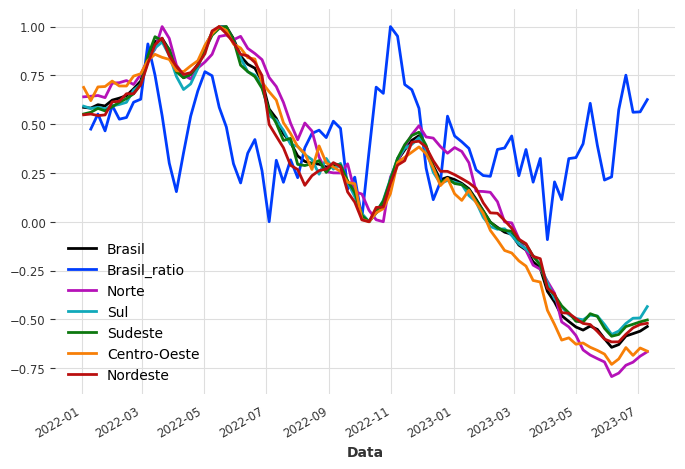

In [21]:
scaler = Scaler()
train_tx_scaled = scaler.fit_transform(train_tx)
val_tx_scaled = scaler.transform(val_tx)
series_national_tx_scaled = scaler.transform(series_national_tx)
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_national_scaled = scaler.transform(series_national)
train_north_scaled = scaler.fit_transform(train_north)
val_north_scaled = scaler.transform(val_north)
series_north_scaled = scaler.transform(series_north)
train_south_scaled = scaler.fit_transform(train_south)
val_south_scaled = scaler.transform(val_south)
series_south_scaled = scaler.transform(series_south)
train_southeast_scaled = scaler.fit_transform(train_southeast)
val_southeast_scaled = scaler.transform(val_southeast)
series_southeast_scaled = scaler.transform(series_southeast)
train_midwest_scaled = scaler.fit_transform(train_midwest)
val_midwest_scaled = scaler.transform(val_midwest)
series_midwest_scaled = scaler.transform(series_midwest)
train_northeast_scaled = scaler.fit_transform(train_northeast)
val_northeast_scaled = scaler.transform(val_northeast)
series_northeast_scaled = scaler.transform(series_northeast)

plot_series([
    series_national_scaled,
    series_national_tx_scaled,
    series_north_scaled,
    series_south_scaled,
    series_southeast_scaled,
    series_midwest_scaled,
    series_northeast_scaled
])

### Aplicando o filtro de média móvel

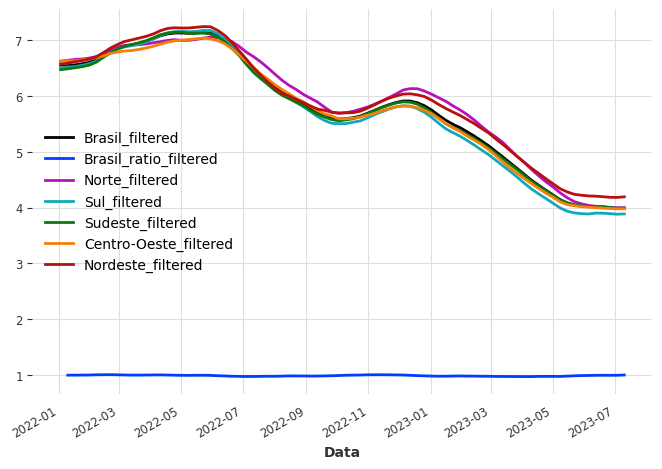

In [22]:
series_national_filtered = series_national.filter()[0]
series_national_tx_filtered = series_national_tx.filter()[0]
series_north_filtered = series_north.filter()[0]
series_south_filtered = series_south.filter()[0]
series_southeast_filtered = series_southeast.filter()[0]
series_midwest_filtered = series_midwest.filter()[0]
series_northeast_filtered = series_northeast.filter()[0]

plot_series([
    series_national_filtered,
    series_national_tx_filtered,
    series_north_filtered,
    series_south_filtered,
    series_southeast_filtered,
    series_midwest_filtered,
    series_northeast_filtered
])

#### Separando em treino e validação

In [23]:
train_size_percent_filtered = 70
train_size_filtered = int(len(series_national_filtered) * train_size_percent_filtered/100)
split_date_filtered = series_national_filtered.time_index[train_size_filtered].strftime('%Y%m%d')
print(f"Treinamento: {series_national_filtered.time_index[0].strftime(DATE_FORMAT_STRING)} - {series_national_filtered.time_index[train_size - 1].strftime(DATE_FORMAT_STRING)}")
print(f"Validação  : {series_national_filtered.time_index[train_size].strftime(DATE_FORMAT_STRING)} - {series_national_filtered.time_index[-1].strftime(DATE_FORMAT_STRING)}")

train_tx_filtered, val_tx_filtered = series_national_tx_filtered.split_before(pd.Timestamp(split_date_filtered))
train_filtered, val_filtered = series_national_filtered.split_before(pd.Timestamp(split_date_filtered))
train_north_filtered, val_north_filtered = series_north_filtered.split_before(pd.Timestamp(split_date_filtered))
train_south_filtered, val_south_filtered = series_south_filtered.split_before(pd.Timestamp(split_date_filtered))
train_southeast_filtered, val_southeast_filtered = series_southeast_filtered.split_before(pd.Timestamp(split_date_filtered))
train_midwest_filtered, val_midwest_filtered = series_midwest_filtered.split_before(pd.Timestamp(split_date_filtered))
train_northeast_filtered, val_northeast_filtered = series_northeast_filtered.split_before(pd.Timestamp(split_date_filtered))

Treinamento: 03/01/2022 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023


#### Novamente verificando sazonalidade

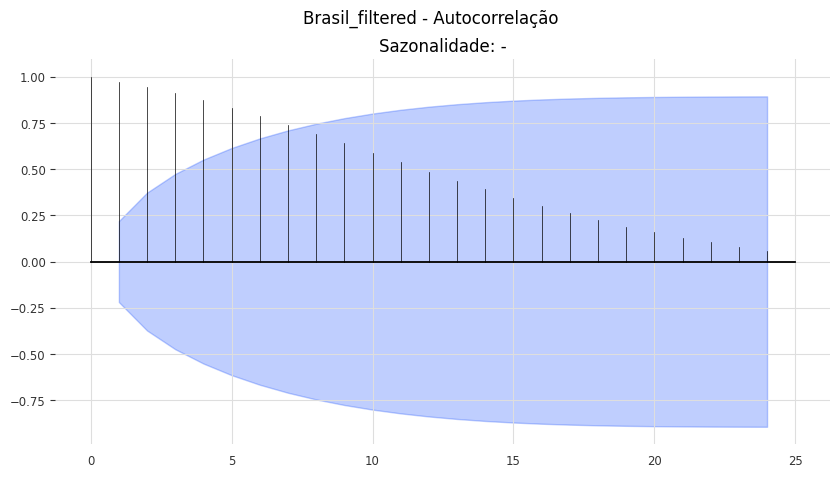

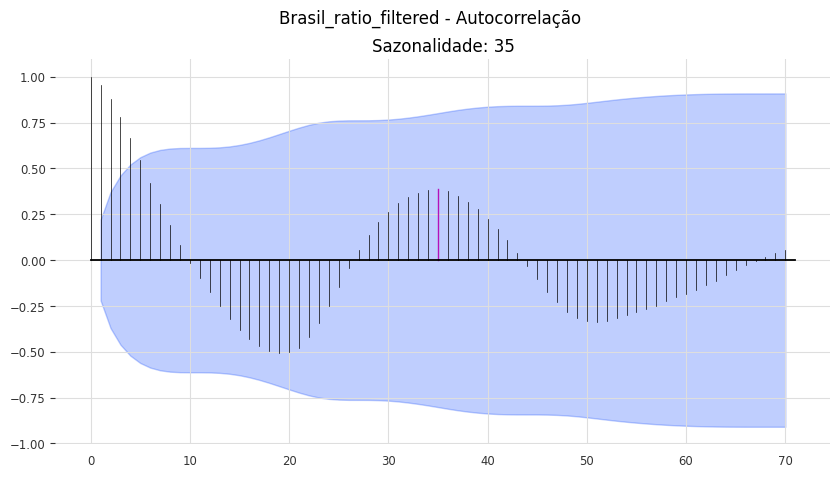

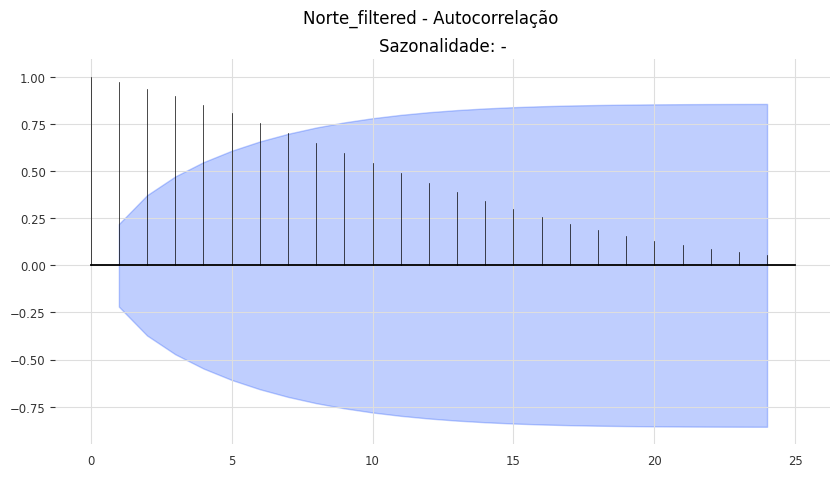

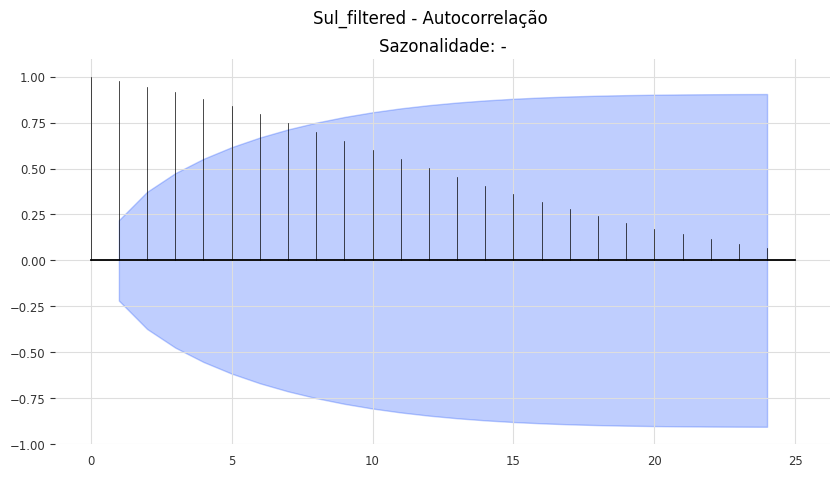

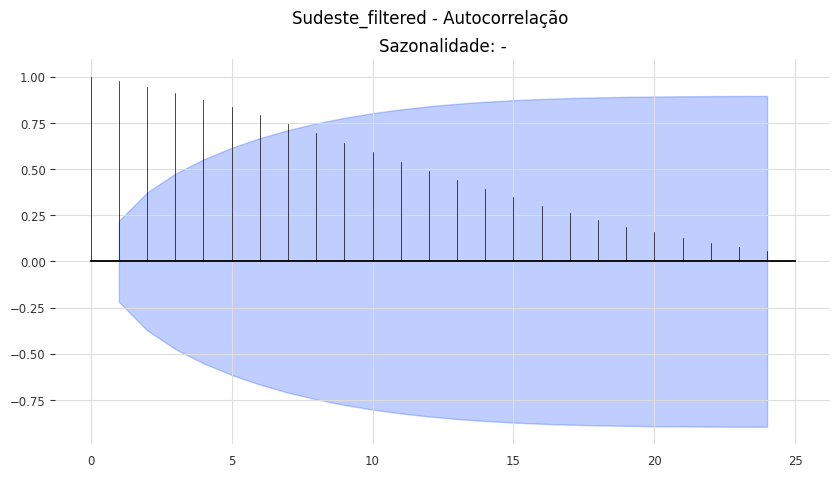

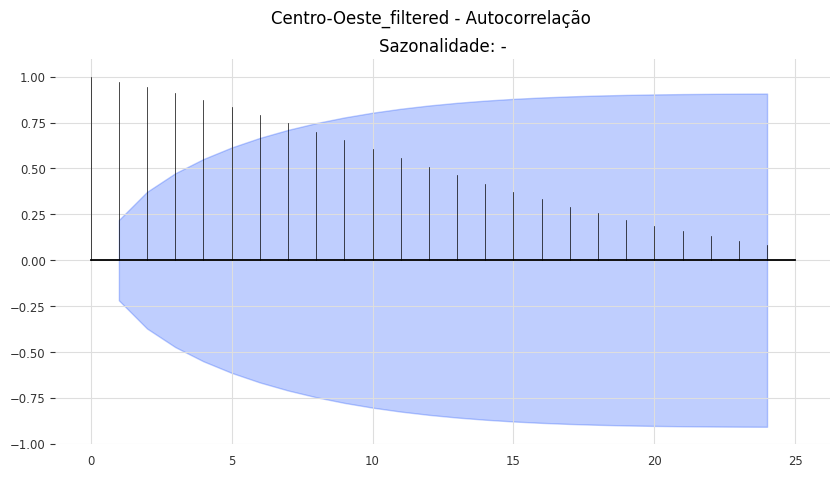

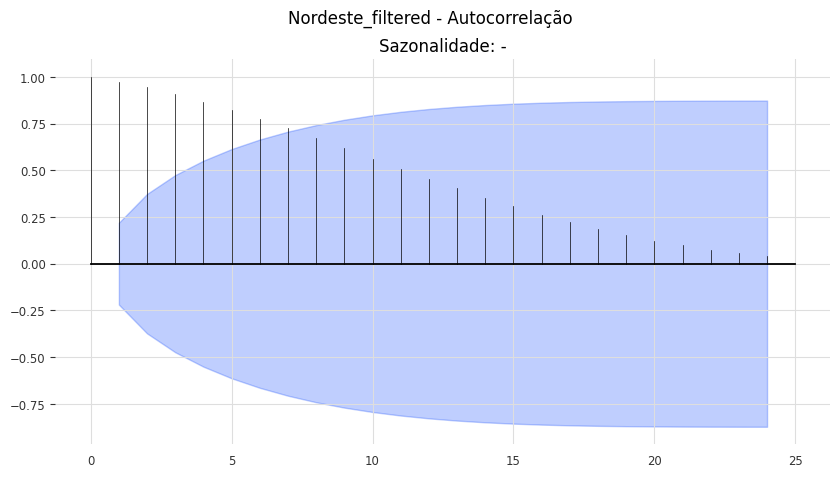

In [24]:
series_national_filtered.plot_acf()
series_national_tx_filtered.plot_acf()
series_north_filtered.plot_acf()
series_south_filtered.plot_acf()
series_southeast_filtered.plot_acf()
series_midwest_filtered.plot_acf()
series_northeast_filtered.plot_acf()

#### Novamente verificando ciclos

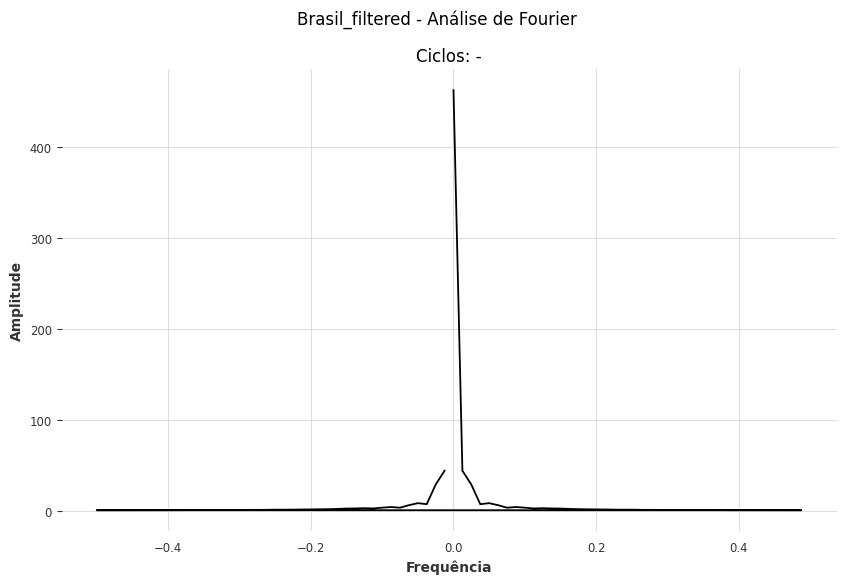

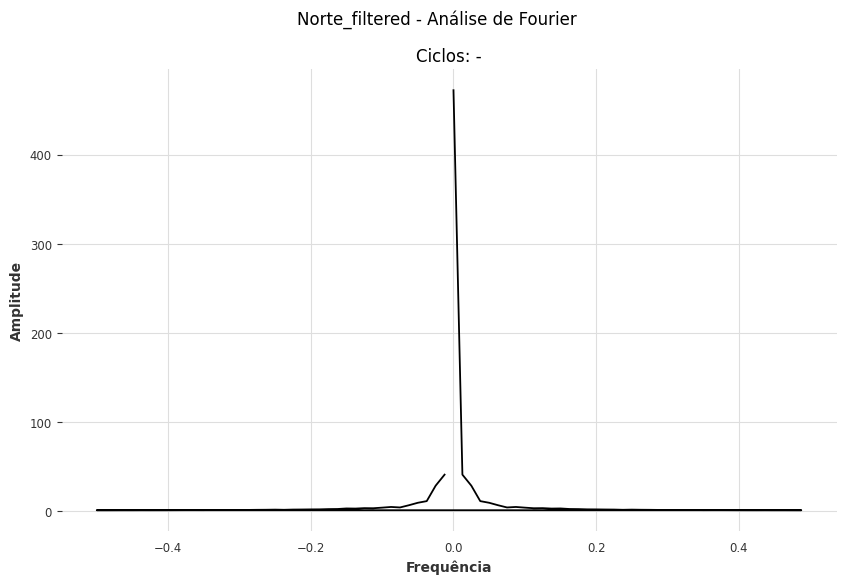

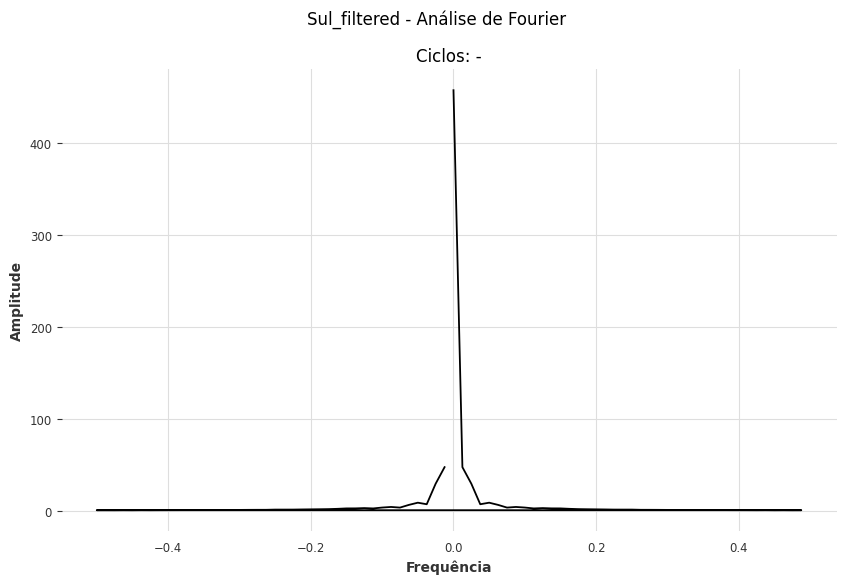

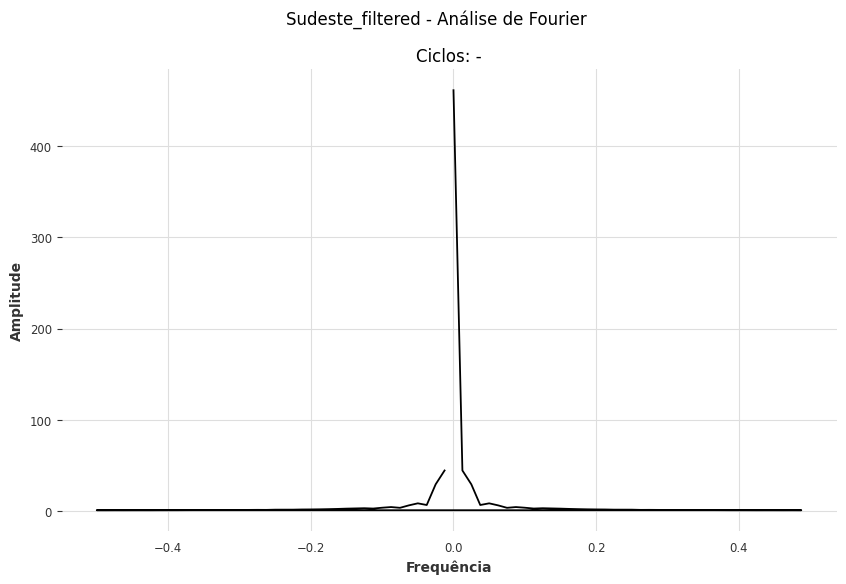

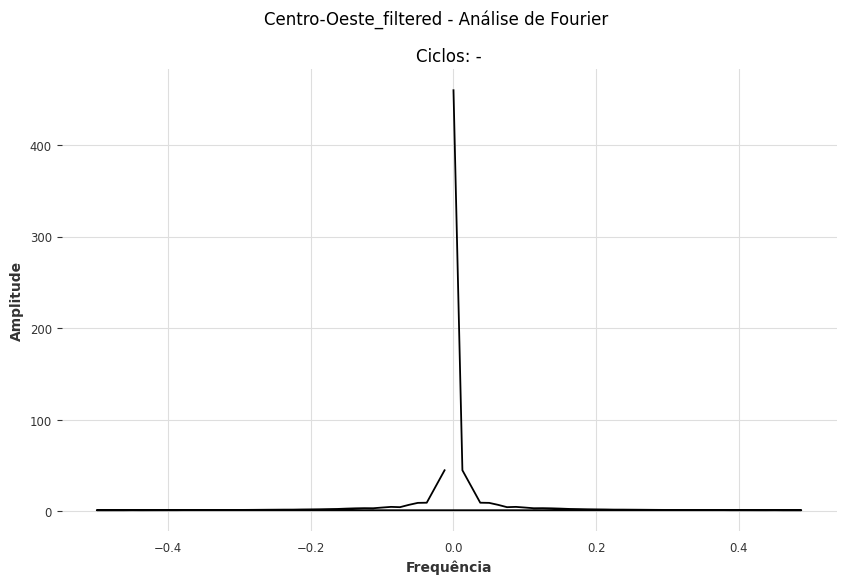

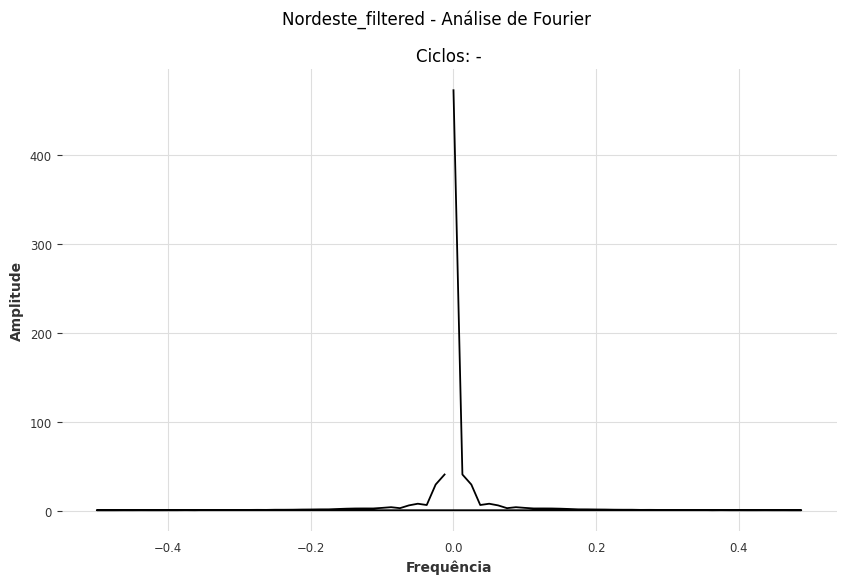

In [25]:
series_national_filtered.plot_fourier_analisys()
series_north_filtered.plot_fourier_analisys()
series_south_filtered.plot_fourier_analisys()
series_southeast_filtered.plot_fourier_analisys()
series_midwest_filtered.plot_fourier_analisys()
series_northeast_filtered.plot_fourier_analisys()

### Aplicando StandardScaler

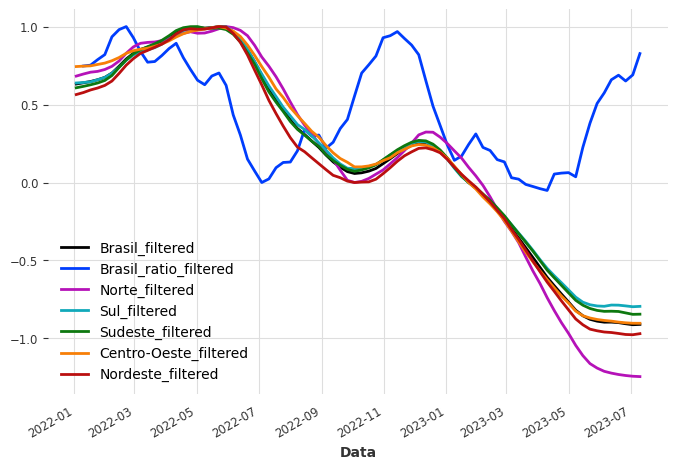

In [26]:
scaler = Scaler()
train_tx_filtered_scaled = scaler.fit_transform(train_tx_filtered)
val_tx_filtered_scaled = scaler.transform(val_tx_filtered)
series_national_tx_filtered_scaled = scaler.transform(series_national_tx_filtered)
train_filtered_scaled = scaler.fit_transform(train_filtered)
val_filtered_scaled = scaler.transform(val_filtered)
series_national_filtered_scaled = scaler.transform(series_national_filtered)
train_north_filtered_scaled = scaler.fit_transform(train_north_filtered)
val_north_filtered_scaled = scaler.transform(val_north_filtered)
series_north_filtered_scaled = scaler.transform(series_north_filtered)
train_south_filtered_scaled = scaler.fit_transform(train_south_filtered)
val_south_filtered_scaled = scaler.transform(val_south_filtered)
series_south_filtered_scaled = scaler.transform(series_south_filtered)
train_southeast_filtered_scaled = scaler.fit_transform(train_southeast_filtered)
val_southeast_filtered_scaled = scaler.transform(val_southeast_filtered)
series_southeast_filtered_scaled = scaler.transform(series_southeast_filtered)
train_midwest_filtered_scaled = scaler.fit_transform(train_midwest_filtered)
val_midwest_filtered_scaled = scaler.transform(val_midwest_filtered)
series_midwest_filtered_scaled = scaler.transform(series_midwest_filtered)
train_northeast_filtered_scaled = scaler.fit_transform(train_northeast_filtered)
val_northeast_filtered_scaled = scaler.transform(val_northeast_filtered)
series_northeast_filtered_scaled = scaler.transform(series_northeast_filtered)

plot_series([
    series_national_filtered_scaled,
    series_national_tx_filtered_scaled,
    series_north_filtered_scaled,
    series_south_filtered_scaled,
    series_southeast_filtered_scaled,
    series_midwest_filtered_scaled,
    series_northeast_filtered_scaled
])

## Tratamento de Dados - Série sem tendência linear

In [59]:
detrend = Detrend()
train_tx_detrend = detrend.fit_transform(train_tx)
val_tx_detrend = detrend.transform(val_tx)
series_national_tx_detrend = detrend.transform(series_national_tx)
train_detrend = detrend.fit_transform(train)
val_detrend = detrend.transform(val)
series_national_detrend = detrend.transform(series_national)
train_north_detrend = detrend.fit_transform(train_north)
val_north_detrend = detrend.transform(val_north)
series_north_detrend = detrend.transform(series_north)
train_south_detrend = detrend.fit_transform(train_south)
val_south_detrend = detrend.transform(val_south)
series_south_detrend = detrend.transform(series_south)
train_southeast_detrend = detrend.fit_transform(train_southeast)
val_southeast_detrend = detrend.transform(val_southeast)
series_southeast_detrend = detrend.transform(series_southeast)
train_midwest_detrend = detrend.fit_transform(train_midwest)
val_midwest_detrend = detrend.transform(val_midwest)
series_midwest_detrend = detrend.transform(series_midwest)
train_northeast_detrend = detrend.fit_transform(train_northeast)
val_northeast_detrend = detrend.transform(val_northeast)
series_northeast_detrend = detrend.transform(series_northeast)

### Visualização dos dados

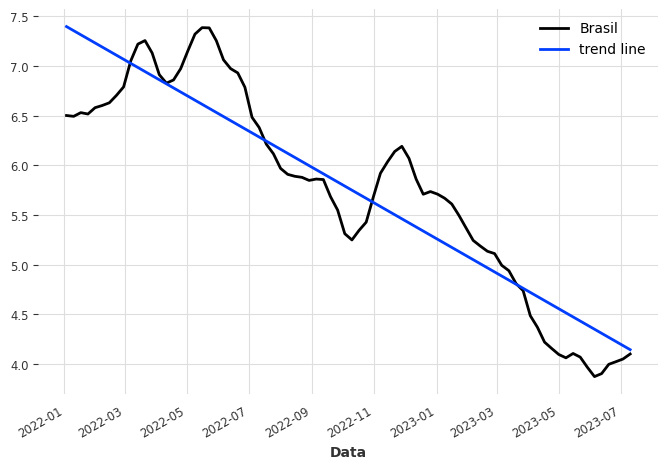

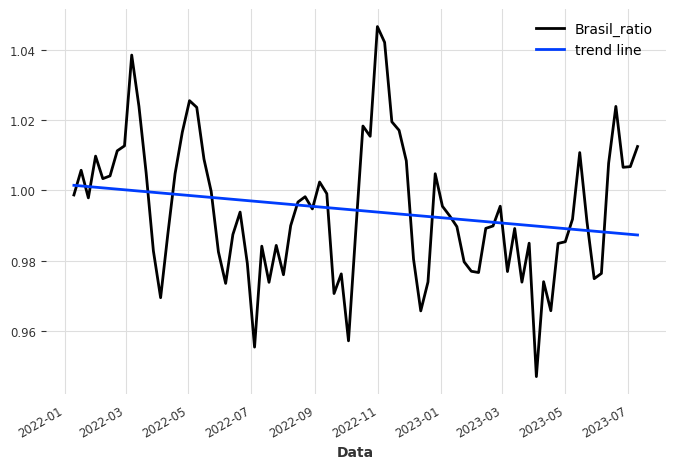

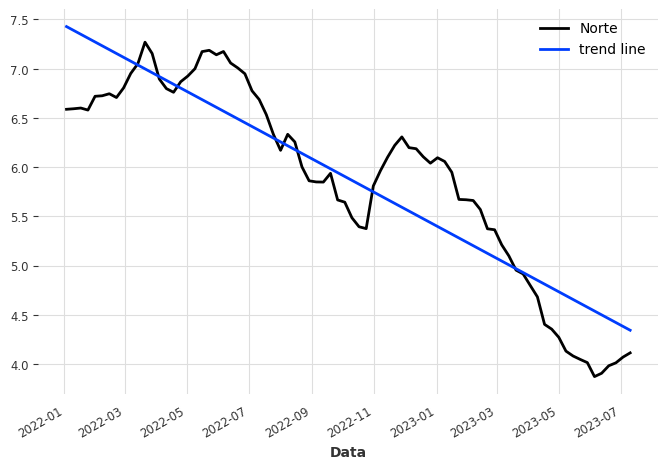

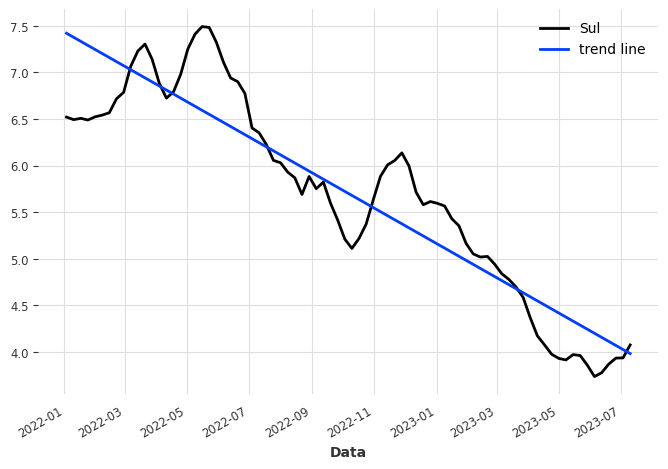

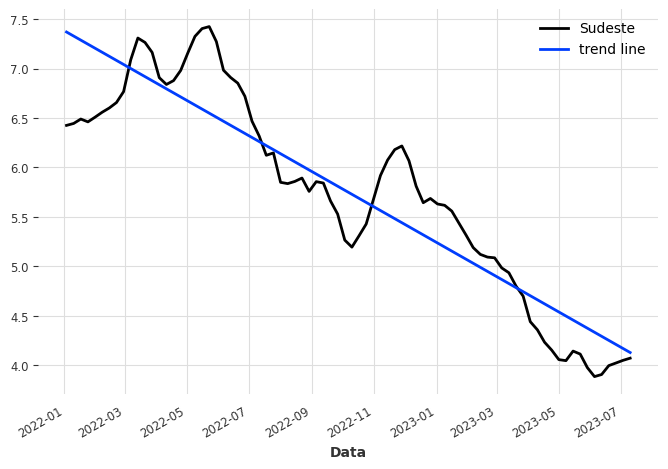

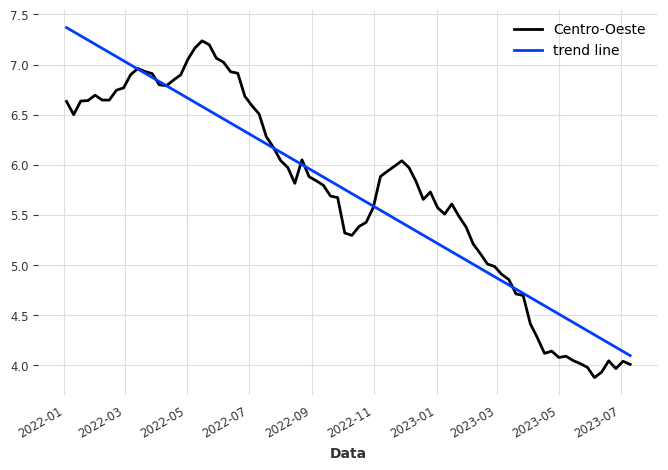

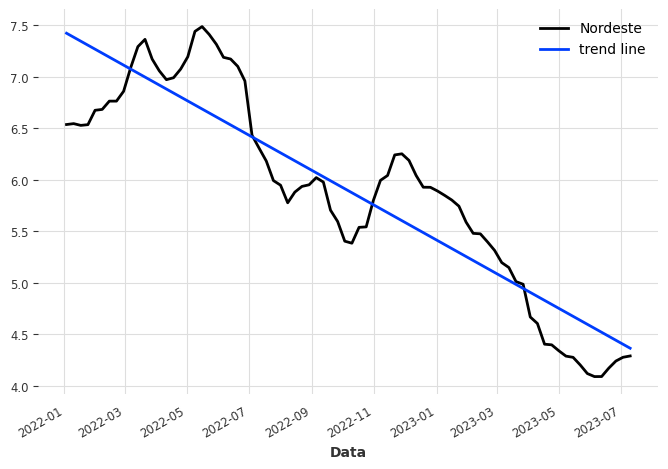

In [60]:
plot_trend_line(series_national)
plot_trend_line(series_national_tx)
plot_trend_line(series_north)
plot_trend_line(series_south)
plot_trend_line(series_southeast)
plot_trend_line(series_midwest)
plot_trend_line(series_northeast)

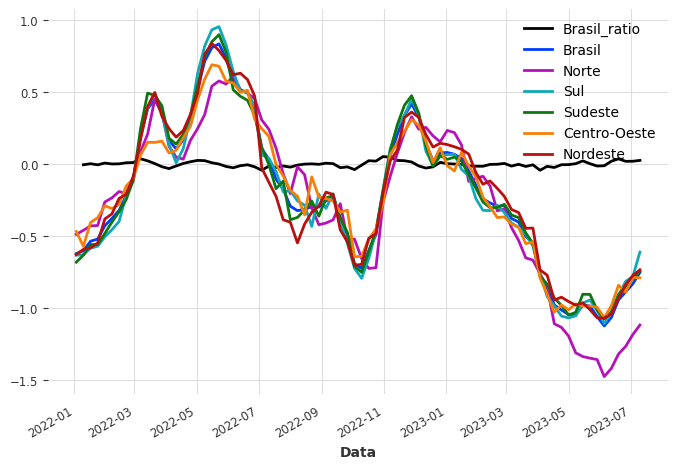

In [61]:
plot_series([
    series_national_tx_detrend,
    series_national_detrend,
    series_north_detrend,
    series_south_detrend,
    series_southeast_detrend,
    series_midwest_detrend,
    series_northeast_detrend
])

### Divisão dos Conjuntos de Treino e Validação

In [62]:
train_size_percent_detrend = 70
train_size_detrend = int(len(series_national_detrend) * train_size_percent_detrend/100)
split_date_detrend = series_national_detrend.time_index[train_size_detrend].strftime('%Y%m%d')
print(f"Treinamento: {series_national_detrend.time_index[0].strftime(DATE_FORMAT_STRING)} - {series_national_detrend.time_index[train_size - 1].strftime(DATE_FORMAT_STRING)}")
print(f"Validação  : {series_national_detrend.time_index[train_size].strftime(DATE_FORMAT_STRING)} - {series_national_detrend.time_index[-1].strftime(DATE_FORMAT_STRING)}")

train_tx_detrend, val_tx_detrend = series_national_tx_detrend.split_before(pd.Timestamp(split_date_detrend))
train_detrend, val_detrend = series_national_detrend.split_before(pd.Timestamp(split_date_detrend))
train_north_detrend, val_north_detrend = series_north_detrend.split_before(pd.Timestamp(split_date_detrend))
train_south_detrend, val_south_detrend = series_south_detrend.split_before(pd.Timestamp(split_date_detrend))
train_southeast_detrend, val_southeast_detrend = series_southeast_detrend.split_before(pd.Timestamp(split_date_detrend))
train_midwest_detrend, val_midwest_detrend = series_midwest_detrend.split_before(pd.Timestamp(split_date_detrend))
train_northeast_detrend, val_northeast_detrend = series_northeast_detrend.split_before(pd.Timestamp(split_date_detrend))

Treinamento: 03/01/2022 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023


### Aplicando StandardScaler (normalização de 0 a 1)

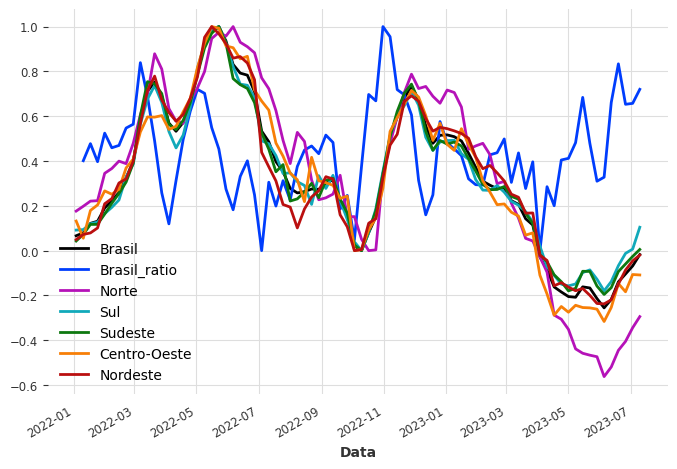

In [63]:
scaler = Scaler()
train_tx_detrend_scaled = scaler.fit_transform(train_tx_detrend)
val_tx_detrend_scaled = scaler.transform(val_tx_detrend)
series_national_tx_detrend_scaled = scaler.transform(series_national_tx_detrend)
train_detrend_scaled = scaler.fit_transform(train_detrend)
val_detrend_scaled = scaler.transform(val_detrend)
series_national_detrend_scaled = scaler.transform(series_national_detrend)
train_north_detrend_scaled = scaler.fit_transform(train_north_detrend)
val_north_detrend_scaled = scaler.transform(val_north_detrend)
series_north_detrend_scaled = scaler.transform(series_north_detrend)
train_south_detrend_scaled = scaler.fit_transform(train_south_detrend)
val_south_detrend_scaled = scaler.transform(val_south_detrend)
series_south_detrend_scaled = scaler.transform(series_south_detrend)
train_southeast_detrend_scaled = scaler.fit_transform(train_southeast_detrend)
val_southeast_detrend_scaled = scaler.transform(val_southeast_detrend)
series_southeast_detrend_scaled = scaler.transform(series_southeast_detrend)
train_midwest_detrend_scaled = scaler.fit_transform(train_midwest_detrend)
val_midwest_detrend_scaled = scaler.transform(val_midwest_detrend)
series_midwest_detrend_scaled = scaler.transform(series_midwest_detrend)
train_northeast_detrend_scaled = scaler.fit_transform(train_northeast_detrend)
val_northeast_detrend_scaled = scaler.transform(val_northeast_detrend)
series_northeast_detrend_scaled = scaler.transform(series_northeast_detrend)

plot_series([
    series_national_detrend_scaled,
    series_national_tx_detrend_scaled,
    series_north_detrend_scaled,
    series_south_detrend_scaled,
    series_southeast_detrend_scaled,
    series_midwest_detrend_scaled,
    series_northeast_detrend_scaled
])

### Aplicando o filtro de média móvel

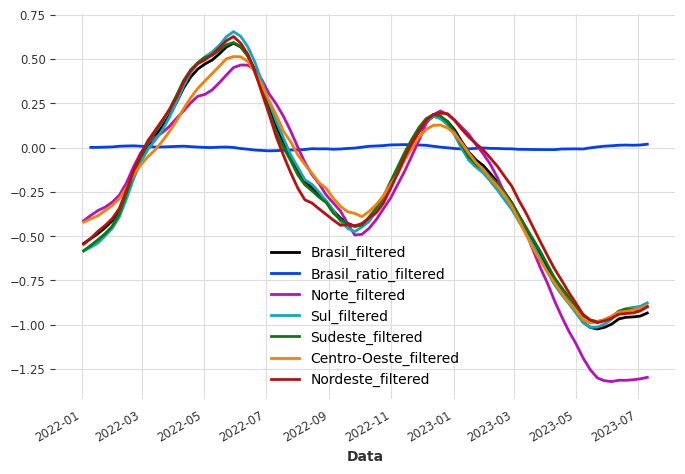

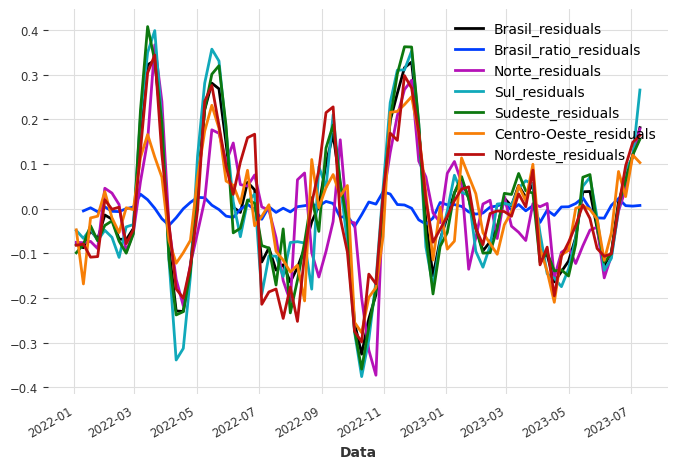

In [64]:
series_national_detrend_filtered, series_national_detrend_residuals = series_national_detrend.filter()
series_national_tx_detrend_filtered, series_national_tx_detrend_residuals = series_national_tx_detrend.filter()
series_north_detrend_filtered, series_north_detrend_residuals = series_north_detrend.filter()
series_south_detrend_filtered, series_south_detrend_residuals = series_south_detrend.filter()
series_southeast_detrend_filtered, series_southeast_detrend_residuals = series_southeast_detrend.filter()
series_midwest_detrend_filtered, series_midwest_detrend_residuals = series_midwest_detrend.filter()
series_northeast_detrend_filtered, series_northeast_detrend_residuals = series_northeast_detrend.filter()

plot_series([
    series_national_detrend_filtered,
    series_national_tx_detrend_filtered,
    series_north_detrend_filtered,
    series_south_detrend_filtered,
    series_southeast_detrend_filtered,
    series_midwest_detrend_filtered,
    series_northeast_detrend_filtered
])

plot_series([
    series_national_detrend_residuals,
    series_national_tx_detrend_residuals,
    series_north_detrend_residuals,
    series_south_detrend_residuals,
    series_southeast_detrend_residuals,
    series_midwest_detrend_residuals,
    series_northeast_detrend_residuals
])

#### Separando em treino e validação

In [65]:
train_size_percent_detrend_filtered = 70
train_size_detrend_filtered = int(len(series_national_detrend_filtered) * train_size_percent_detrend_filtered/100)
split_date_detrend_filtered = series_national_detrend_filtered.time_index[train_size_detrend_filtered].strftime('%Y%m%d')
print(f"Treinamento: {series_national_detrend_filtered.time_index[0].strftime(DATE_FORMAT_STRING)} - {series_national_detrend_filtered.time_index[train_size - 1].strftime(DATE_FORMAT_STRING)}")
print(f"Validação  : {series_national_detrend_filtered.time_index[train_size].strftime(DATE_FORMAT_STRING)} - {series_national_detrend_filtered.time_index[-1].strftime(DATE_FORMAT_STRING)}")

train_tx_detrend_filtered, val_tx_detrend_filtered = series_national_tx_detrend_filtered.split_before(pd.Timestamp(split_date_detrend_filtered))
train_detrend_filtered, val_detrend_filtered = series_national_detrend_filtered.split_before(pd.Timestamp(split_date_detrend_filtered))
train_north_detrend_filtered, val_north_detrend_filtered = series_north_detrend_filtered.split_before(pd.Timestamp(split_date_detrend_filtered))
train_south_detrend_filtered, val_south_detrend_filtered = series_south_detrend_filtered.split_before(pd.Timestamp(split_date_detrend_filtered))
train_southeast_detrend_filtered, val_southeast_detrend_filtered = series_southeast_detrend_filtered.split_before(pd.Timestamp(split_date_detrend_filtered))
train_midwest_detrend_filtered, val_midwest_detrend_filtered = series_midwest_detrend_filtered.split_before(pd.Timestamp(split_date_detrend_filtered))
train_northeast_detrend_filtered, val_northeast_detrend_filtered = series_northeast_detrend_filtered.split_before(pd.Timestamp(split_date_detrend_filtered))

train_tx_detrend_residuals, val_tx_detrend_residuals = series_national_tx_detrend_residuals.split_before(pd.Timestamp(split_date_detrend_filtered))
train_detrend_residuals, val_detrend_residuals = series_national_detrend_residuals.split_before(pd.Timestamp(split_date_detrend_filtered))
train_north_detrend_residuals, val_north_detrend_residuals = series_north_detrend_residuals.split_before(pd.Timestamp(split_date_detrend_filtered))
train_south_detrend_residuals, val_south_detrend_residuals = series_south_detrend_residuals.split_before(pd.Timestamp(split_date_detrend_filtered))
train_southeast_detrend_residuals, val_southeast_detrend_residuals = series_southeast_detrend_residuals.split_before(pd.Timestamp(split_date_detrend_filtered))
train_midwest_detrend_residuals, val_midwest_detrend_residuals = series_midwest_detrend_residuals.split_before(pd.Timestamp(split_date_detrend_filtered))
train_northeast_detrend_residuals, val_northeast_detrend_residuals = series_northeast_detrend_residuals.split_before(pd.Timestamp(split_date_detrend_filtered))

Treinamento: 03/01/2022 - 23/01/2023
Validação  : 30/01/2023 - 10/07/2023


#### Novamente verificando sazonalidade

##### Série Filtrada

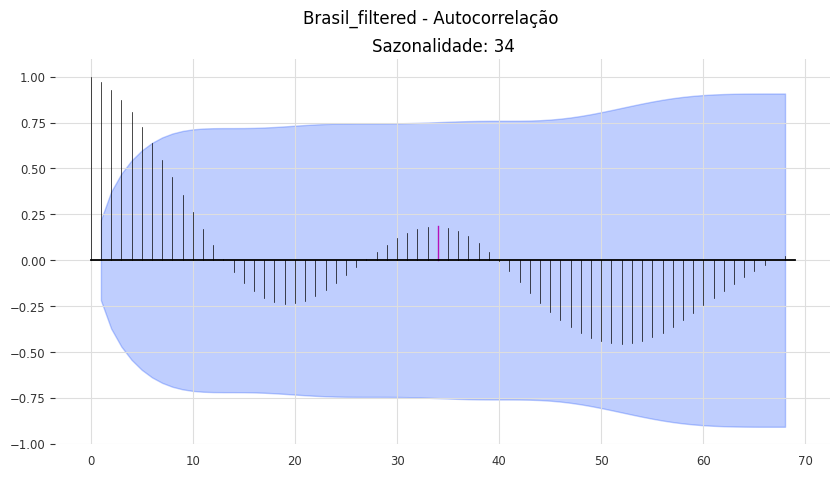

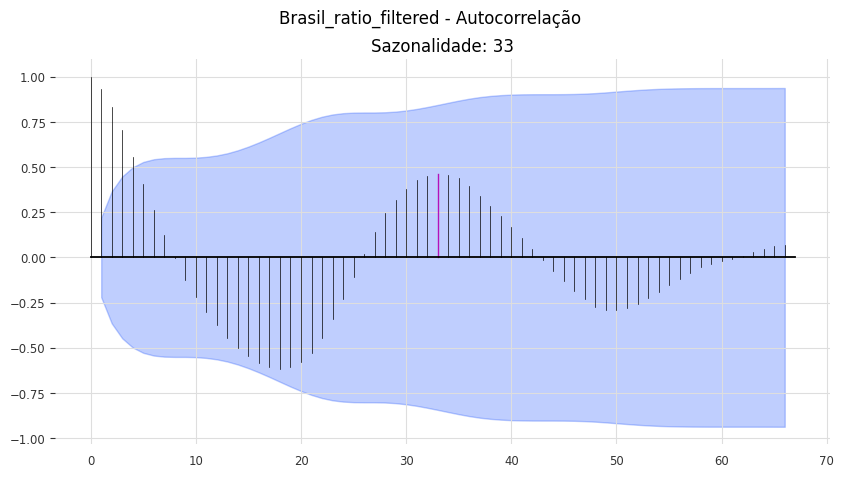

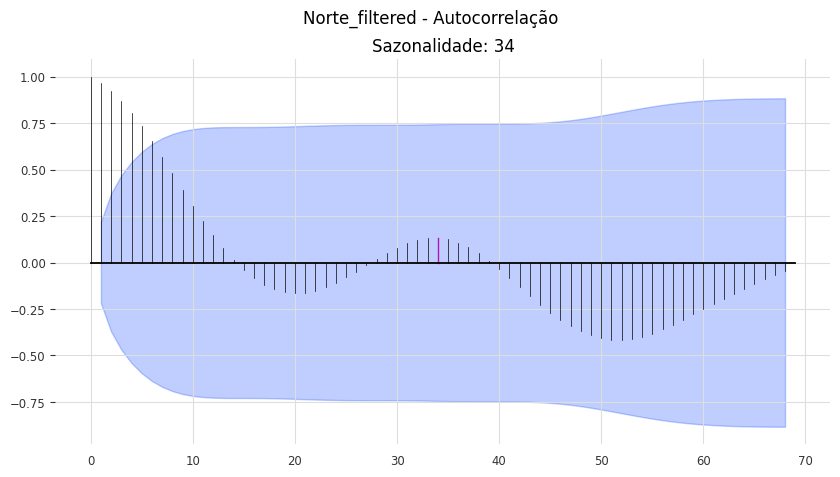

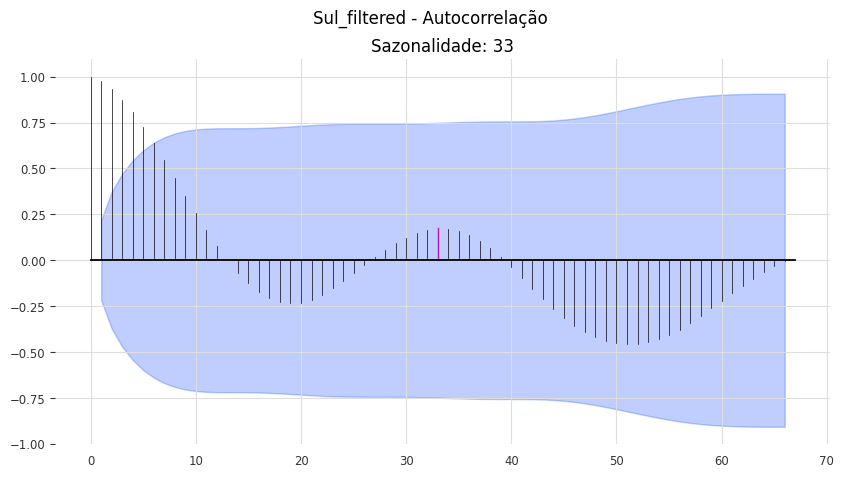

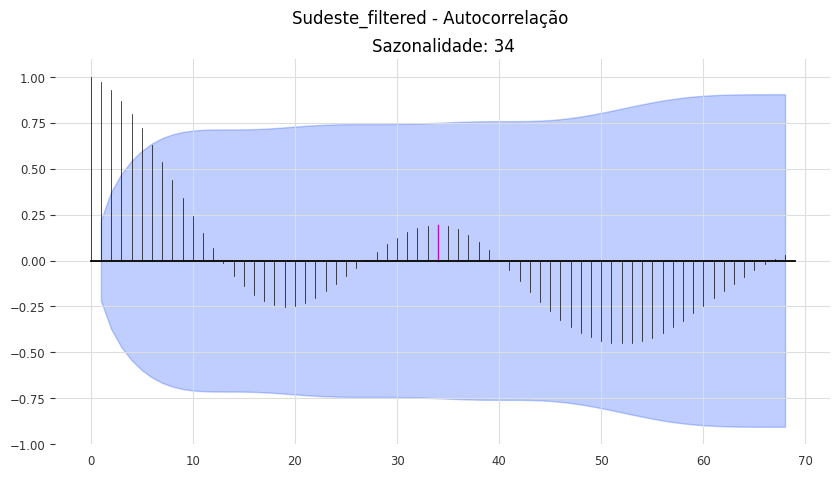

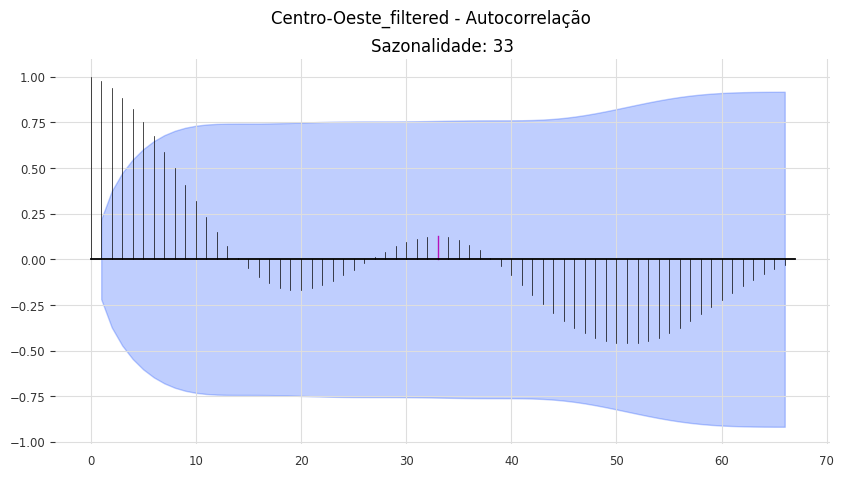

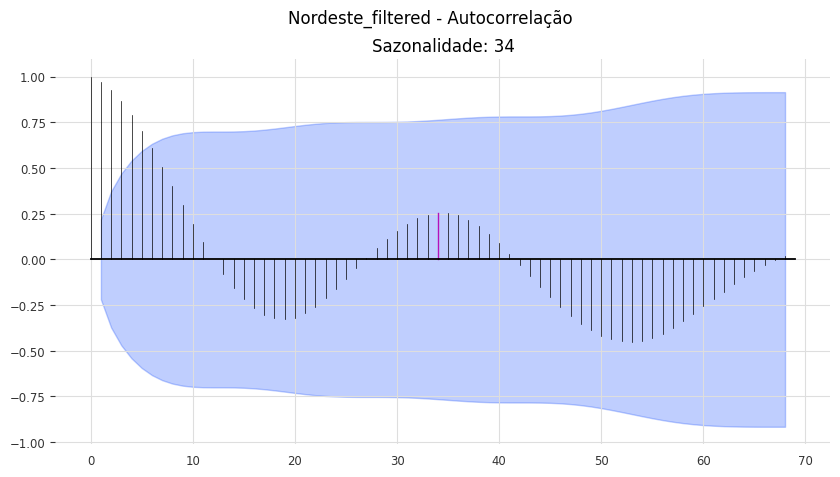

In [66]:
series_national_detrend_filtered.plot_acf()
series_national_tx_detrend_filtered.plot_acf()
series_north_detrend_filtered.plot_acf()
series_south_detrend_filtered.plot_acf()
series_southeast_detrend_filtered.plot_acf()
series_midwest_detrend_filtered.plot_acf()
series_northeast_detrend_filtered.plot_acf()

##### Resíduo


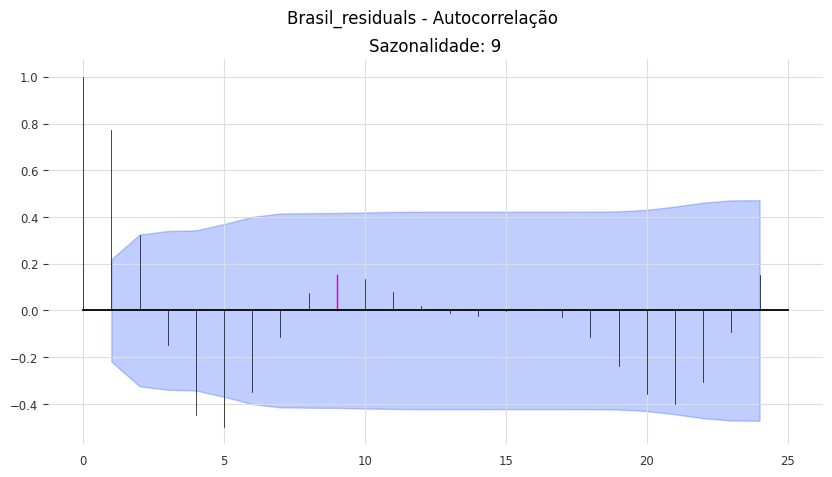

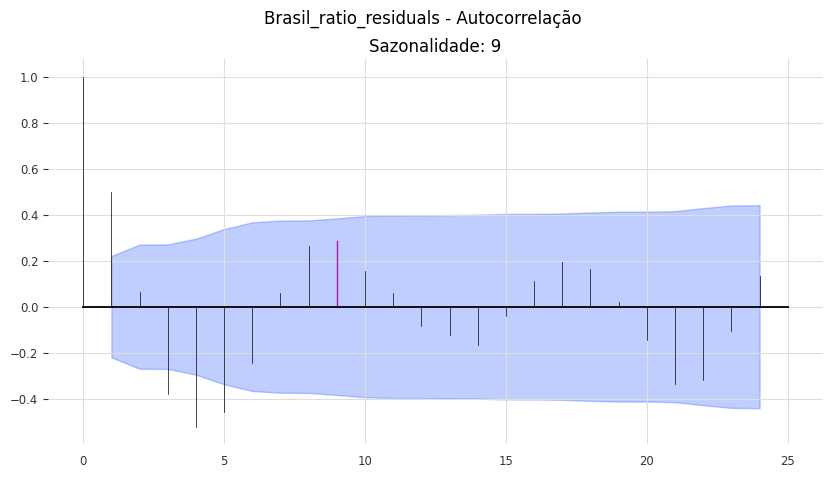

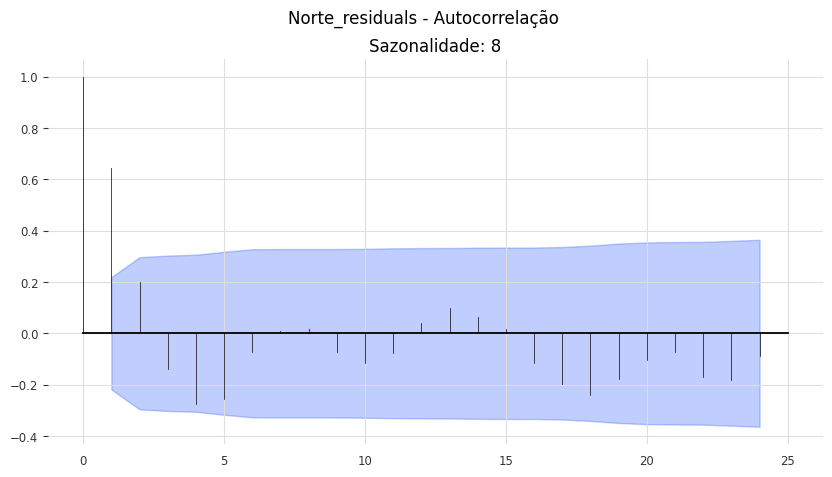

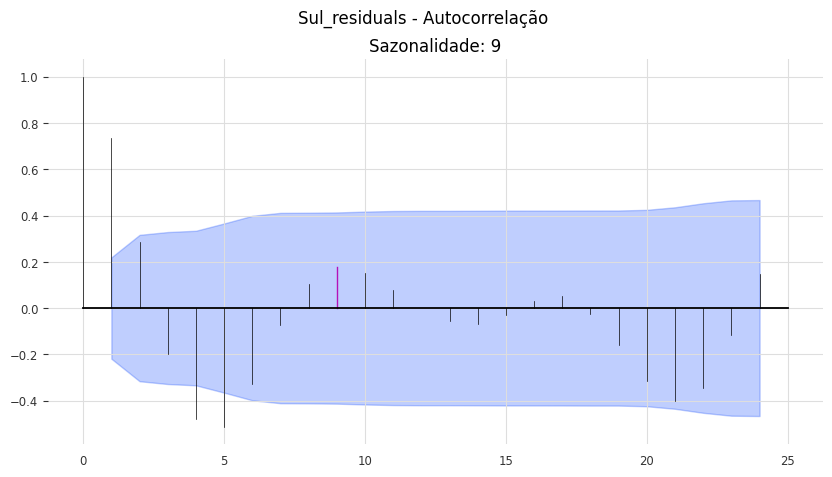

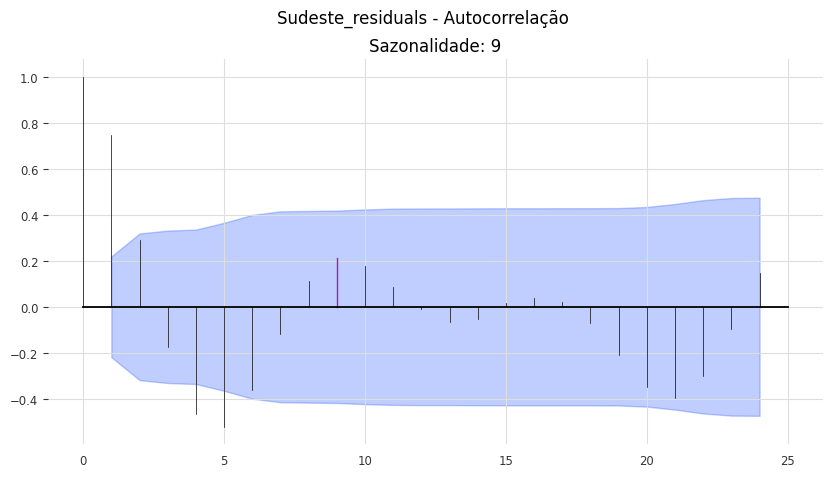

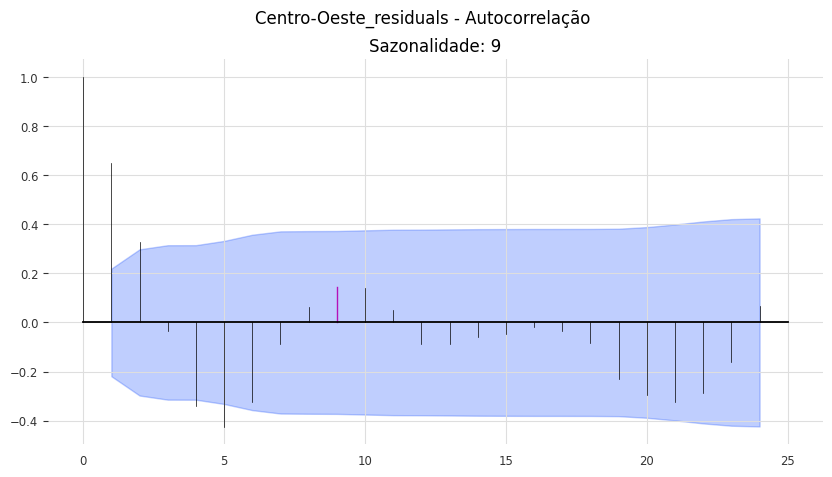

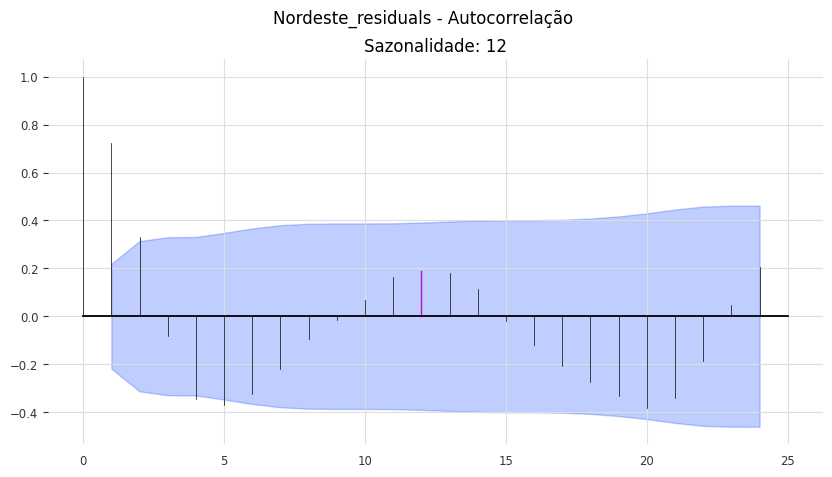

In [67]:
series_national_detrend_residuals.plot_acf()
series_national_tx_detrend_residuals.plot_acf()
series_north_detrend_residuals.plot_acf()
series_south_detrend_residuals.plot_acf()
series_southeast_detrend_residuals.plot_acf()
series_midwest_detrend_residuals.plot_acf()
series_northeast_detrend_residuals.plot_acf()

#### Novamente verificando ciclos

##### Série filtrada

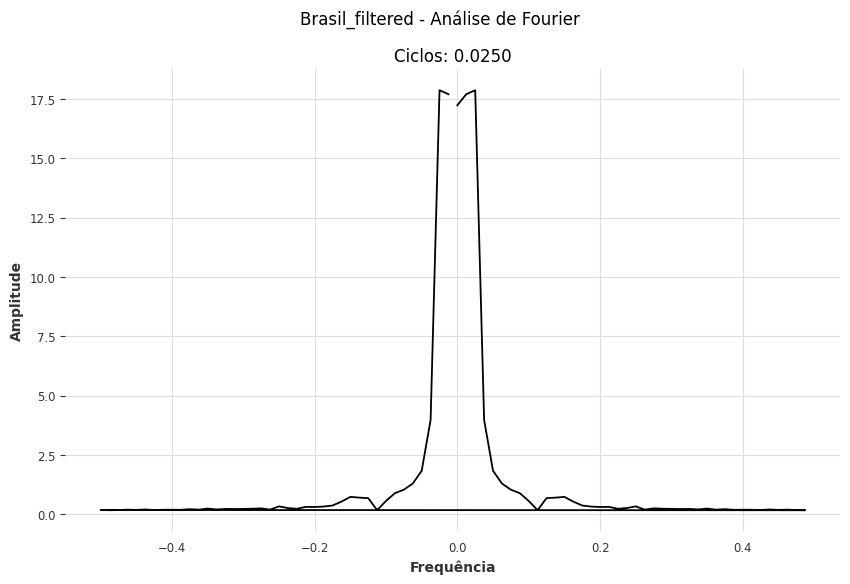

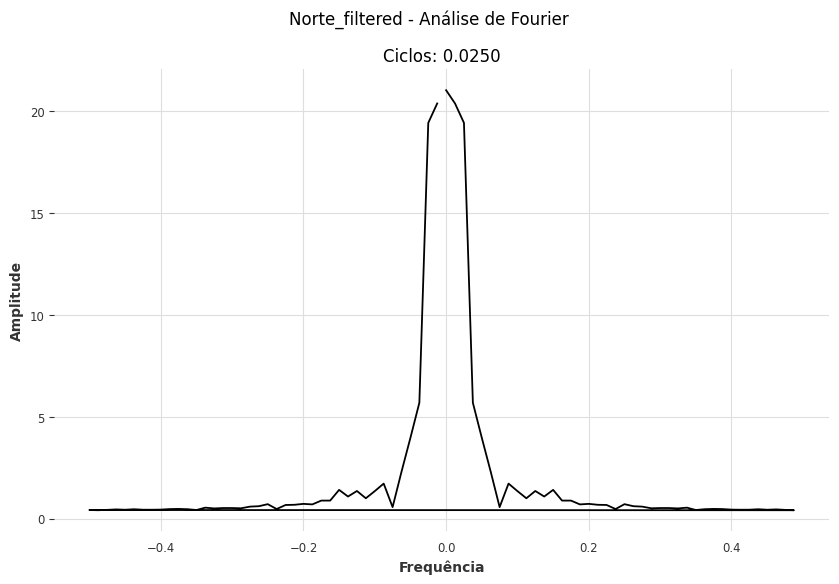

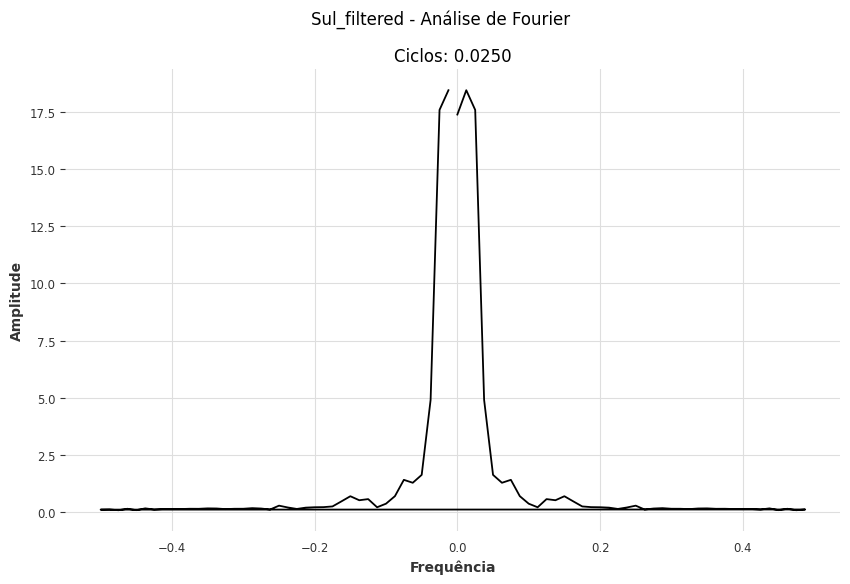

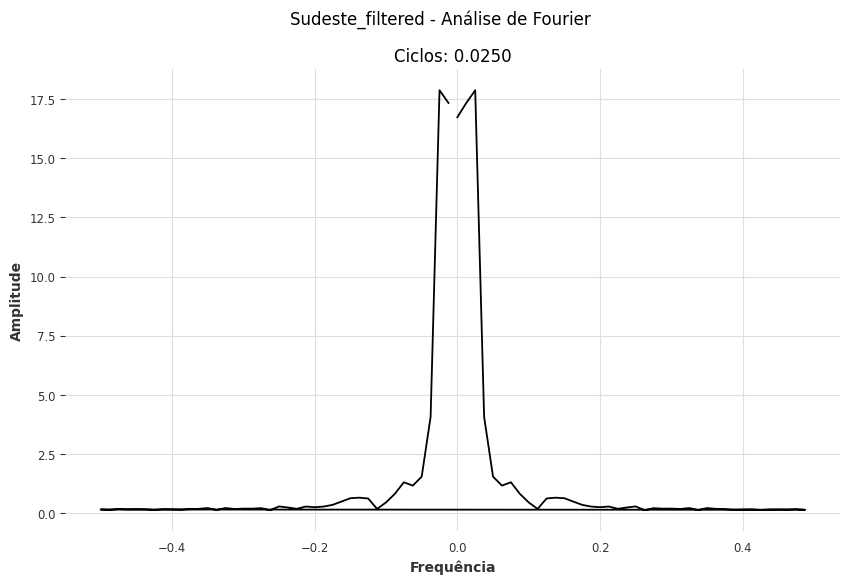

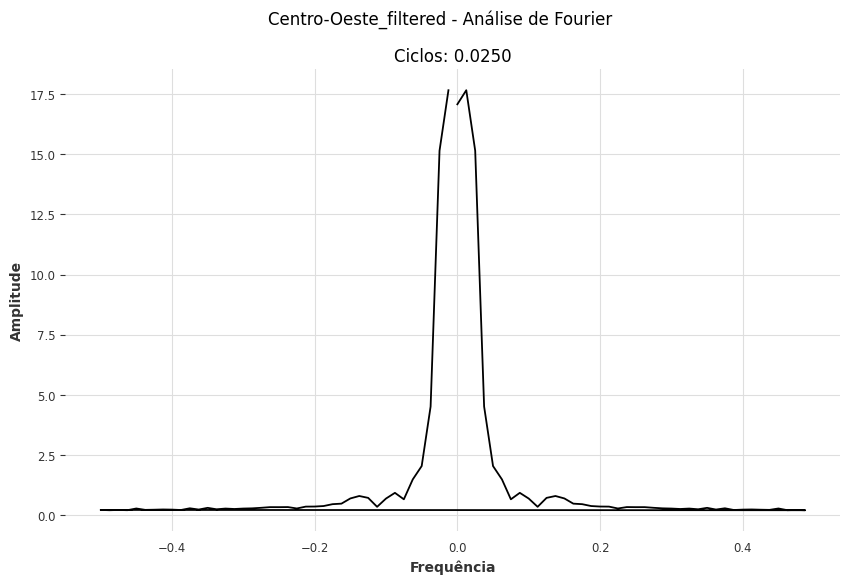

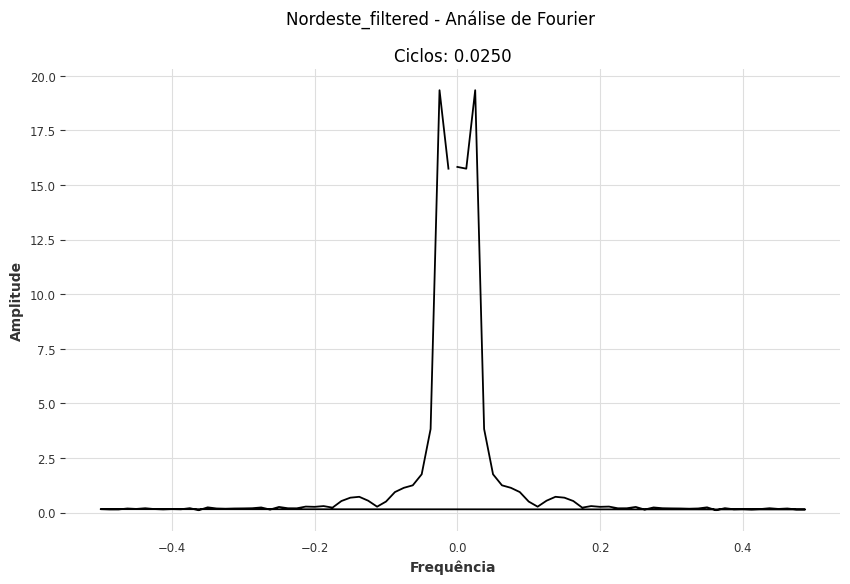

In [68]:
series_national_detrend_filtered.plot_fourier_analisys()
series_north_detrend_filtered.plot_fourier_analisys()
series_south_detrend_filtered.plot_fourier_analisys()
series_southeast_detrend_filtered.plot_fourier_analisys()
series_midwest_detrend_filtered.plot_fourier_analisys()
series_northeast_detrend_filtered.plot_fourier_analisys()

##### Resíduo

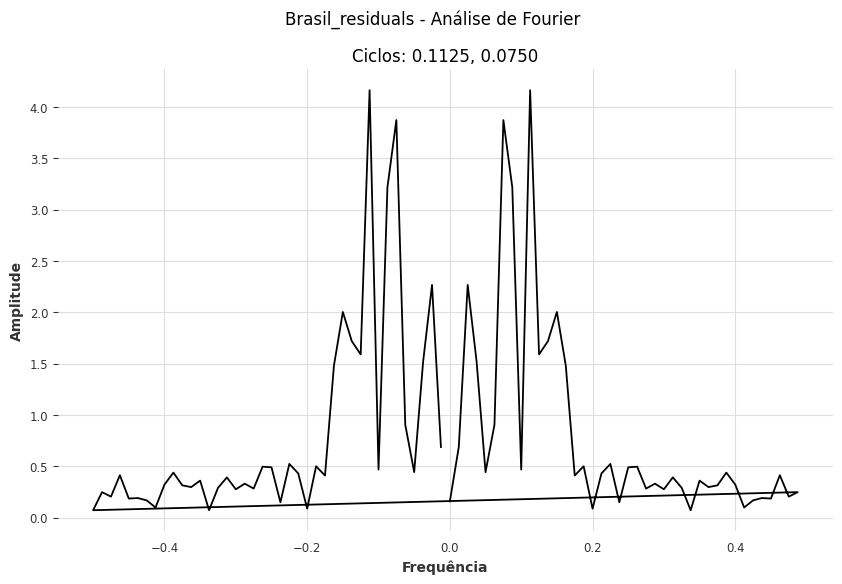

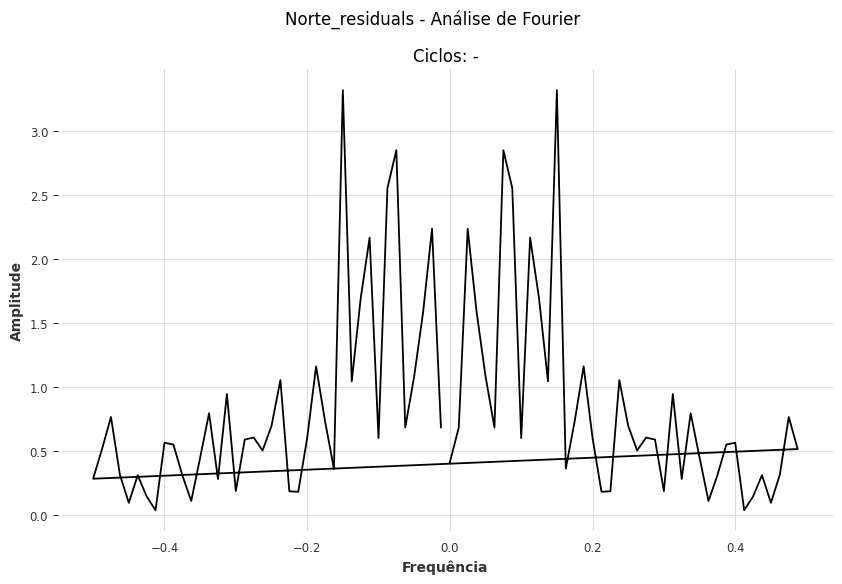

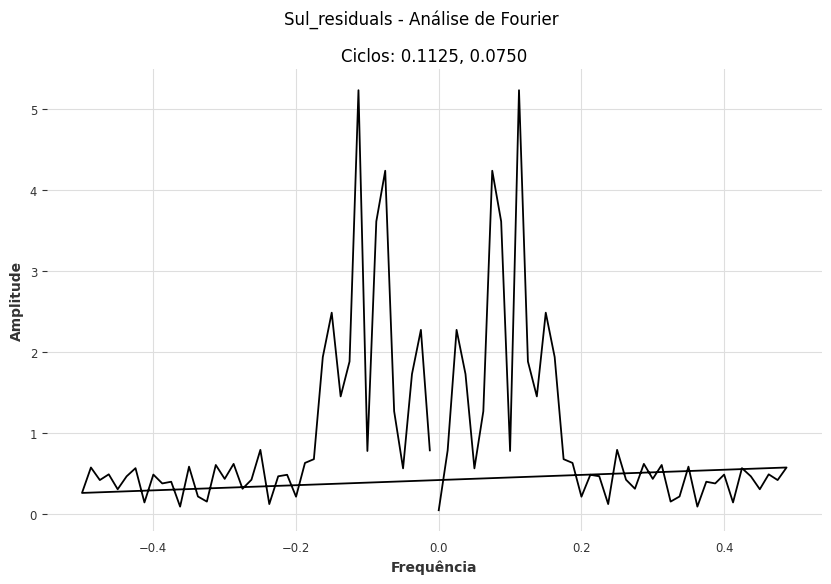

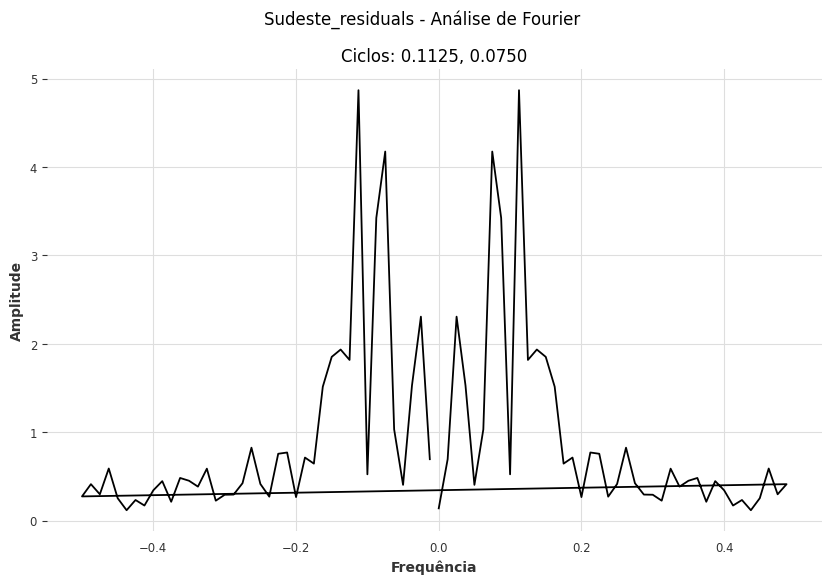

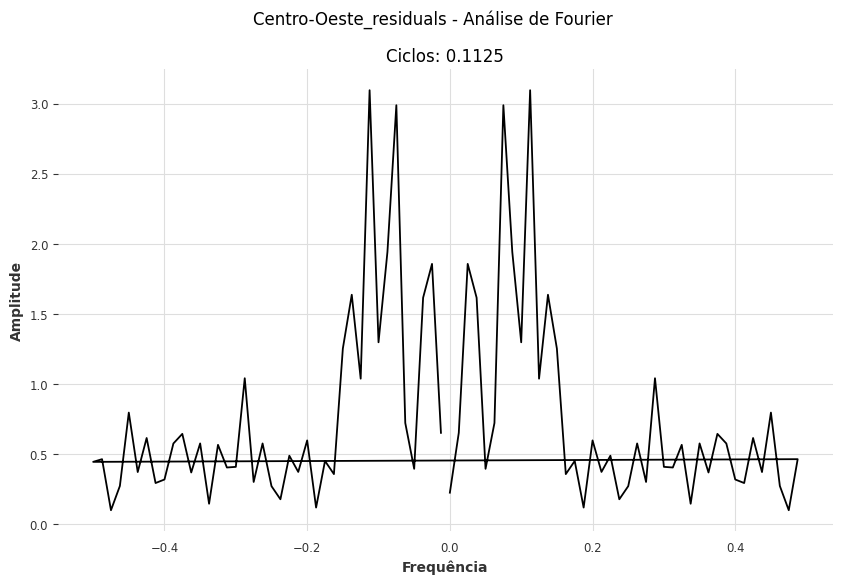

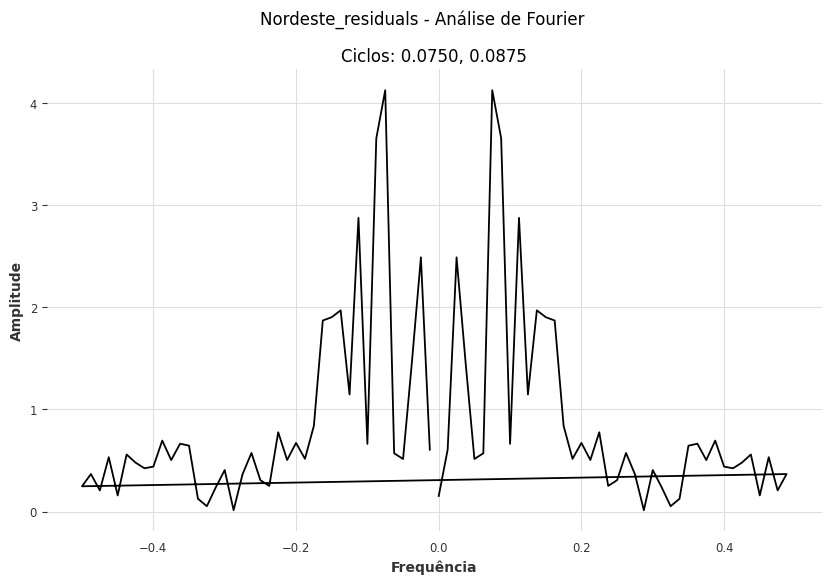

In [69]:
series_national_detrend_residuals.plot_fourier_analisys()
series_north_detrend_residuals.plot_fourier_analisys()
series_south_detrend_residuals.plot_fourier_analisys()
series_southeast_detrend_residuals.plot_fourier_analisys()
series_midwest_detrend_residuals.plot_fourier_analisys()
series_northeast_detrend_residuals.plot_fourier_analisys()

#### Aplicando StandardScaler

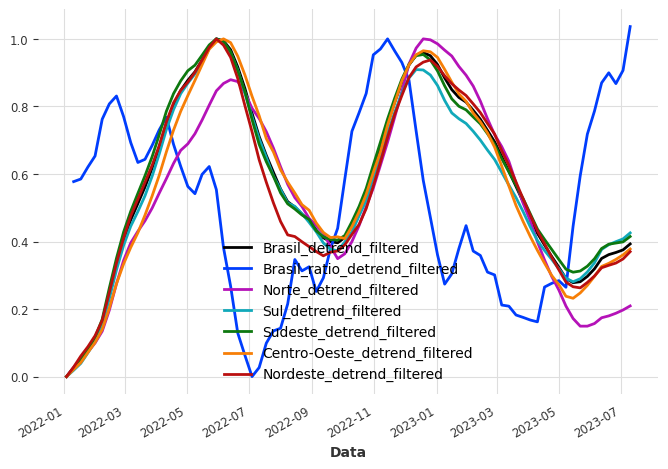

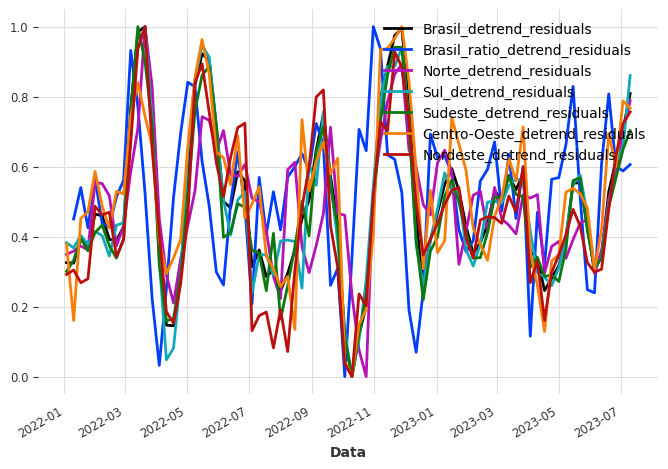

In [38]:
scaler = Scaler()
train_tx_detrend_filtered_scaled = scaler.fit_transform(train_tx_detrend_filtered)
val_tx_detrend_filtered_scaled = scaler.transform(val_tx_detrend_filtered)
series_national_tx_detrend_filtered_scaled = scaler.transform(series_national_tx_detrend_filtered)
train_detrend_filtered_scaled = scaler.fit_transform(train_detrend_filtered)
val_detrend_filtered_scaled = scaler.transform(val_detrend_filtered)
series_national_detrend_filtered_scaled = scaler.transform(series_national_detrend_filtered)
train_north_detrend_filtered_scaled = scaler.fit_transform(train_north_detrend_filtered)
val_north_detrend_filtered_scaled = scaler.transform(val_north_detrend_filtered)
series_north_detrend_filtered_scaled = scaler.transform(series_north_detrend_filtered)
train_south_detrend_filtered_scaled = scaler.fit_transform(train_south_detrend_filtered)
val_south_detrend_filtered_scaled = scaler.transform(val_south_detrend_filtered)
series_south_detrend_filtered_scaled = scaler.transform(series_south_detrend_filtered)
train_southeast_detrend_filtered_scaled = scaler.fit_transform(train_southeast_detrend_filtered)
val_southeast_detrend_filtered_scaled = scaler.transform(val_southeast_detrend_filtered)
series_southeast_detrend_filtered_scaled = scaler.transform(series_southeast_detrend_filtered)
train_midwest_detrend_filtered_scaled = scaler.fit_transform(train_midwest_detrend_filtered)
val_midwest_detrend_filtered_scaled = scaler.transform(val_midwest_detrend_filtered)
series_midwest_detrend_filtered_scaled = scaler.transform(series_midwest_detrend_filtered)
train_northeast_detrend_filtered_scaled = scaler.fit_transform(train_northeast_detrend_filtered)
val_northeast_detrend_filtered_scaled = scaler.transform(val_northeast_detrend_filtered)
series_northeast_detrend_filtered_scaled = scaler.transform(series_northeast_detrend_filtered)

train_tx_detrend_residuals_scaled = scaler.fit_transform(train_tx_detrend_residuals)
val_tx_detrend_residuals_scaled = scaler.transform(val_tx_detrend_residuals)
series_national_tx_detrend_residuals_scaled = scaler.transform(series_national_tx_detrend_residuals)
train_detrend_residuals_scaled = scaler.fit_transform(train_detrend_residuals)
val_detrend_residuals_scaled = scaler.transform(val_detrend_residuals)
series_national_detrend_residuals_scaled = scaler.transform(series_national_detrend_residuals)
train_north_detrend_residuals_scaled = scaler.fit_transform(train_north_detrend_residuals)
val_north_detrend_residuals_scaled = scaler.transform(val_north_detrend_residuals)
series_north_detrend_residuals_scaled = scaler.transform(series_north_detrend_residuals)
train_south_detrend_residuals_scaled = scaler.fit_transform(train_south_detrend_residuals)
val_south_detrend_residuals_scaled = scaler.transform(val_south_detrend_residuals)
series_south_detrend_residuals_scaled = scaler.transform(series_south_detrend_residuals)
train_southeast_detrend_residuals_scaled = scaler.fit_transform(train_southeast_detrend_residuals)
val_southeast_detrend_residuals_scaled = scaler.transform(val_southeast_detrend_residuals)
series_southeast_detrend_residuals_scaled = scaler.transform(series_southeast_detrend_residuals)
train_midwest_detrend_residuals_scaled = scaler.fit_transform(train_midwest_detrend_residuals)
val_midwest_detrend_residuals_scaled = scaler.transform(val_midwest_detrend_residuals)
series_midwest_detrend_residuals_scaled = scaler.transform(series_midwest_detrend_residuals)
train_northeast_detrend_residuals_scaled = scaler.fit_transform(train_northeast_detrend_residuals)
val_northeast_detrend_residuals_scaled = scaler.transform(val_northeast_detrend_residuals)
series_northeast_detrend_residuals_scaled = scaler.transform(series_northeast_detrend_residuals)

plot_series([
    series_national_detrend_filtered_scaled,
    series_national_tx_detrend_filtered_scaled,
    series_north_detrend_filtered_scaled,
    series_south_detrend_filtered_scaled,
    series_southeast_detrend_filtered_scaled,
    series_midwest_detrend_filtered_scaled,
    series_northeast_detrend_filtered_scaled
])
plot_series([
    series_national_detrend_residuals_scaled,
    series_national_tx_detrend_residuals_scaled,
    series_north_detrend_residuals_scaled,
    series_south_detrend_residuals_scaled,
    series_southeast_detrend_residuals_scaled,
    series_midwest_detrend_residuals_scaled,
    series_northeast_detrend_residuals_scaled
])

# Treinando o Modelo

## Usando ARIMA na série filtrada

p: 12, d: 1


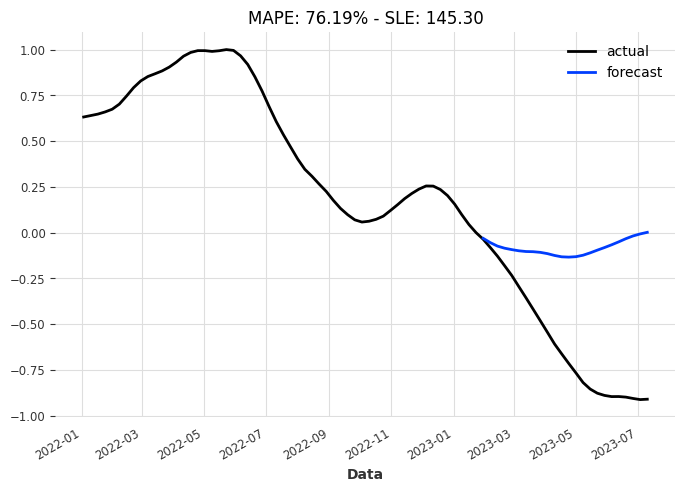

p: 12, d: 2


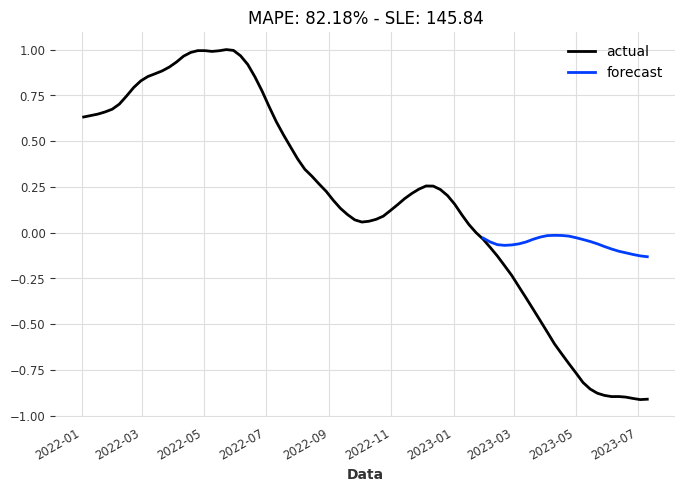

p: 16, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


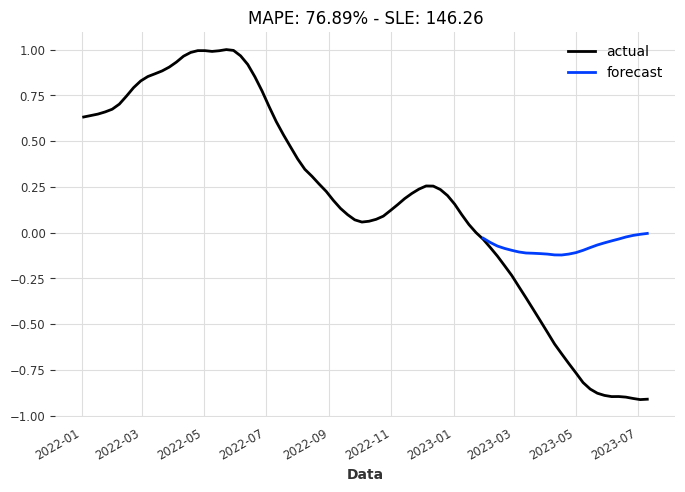

p: 16, d: 2


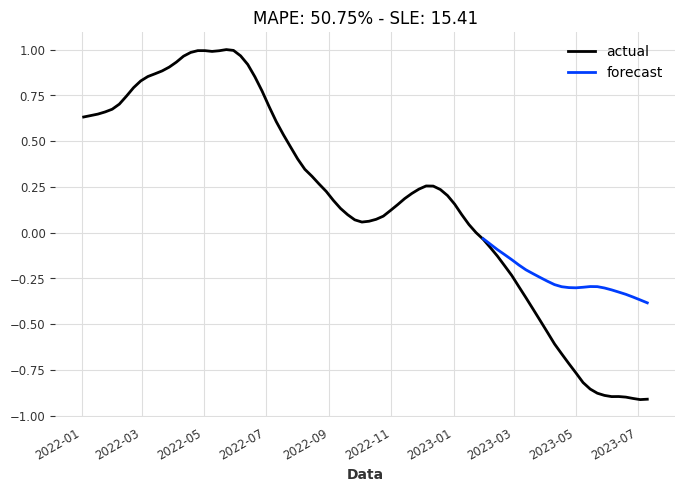

p: 20, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


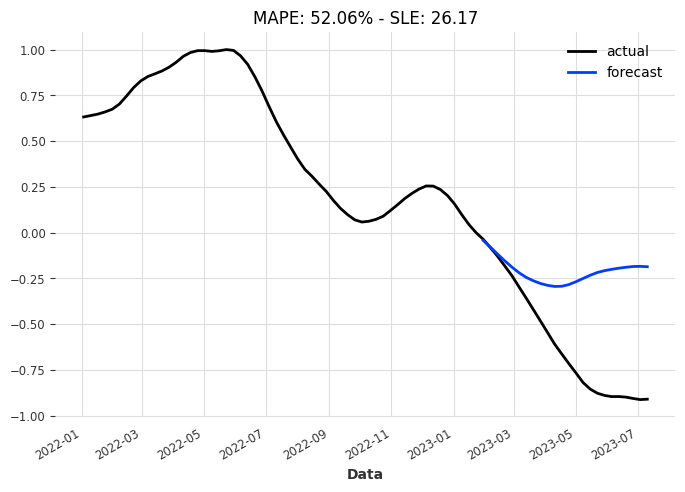

p: 20, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


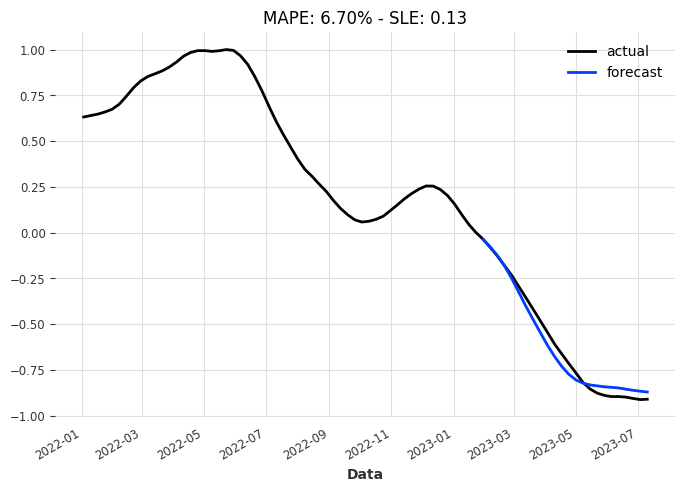

p: 24, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


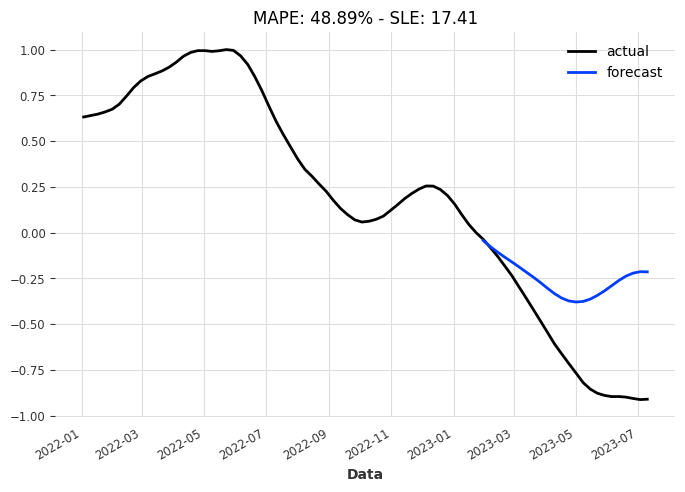

p: 24, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


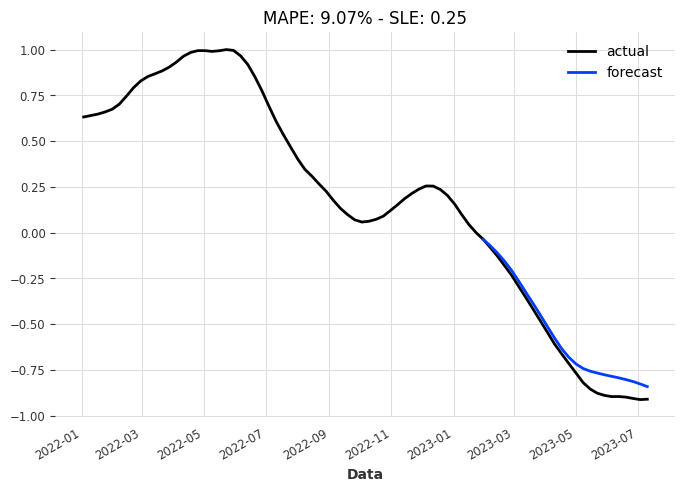

p: 28, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


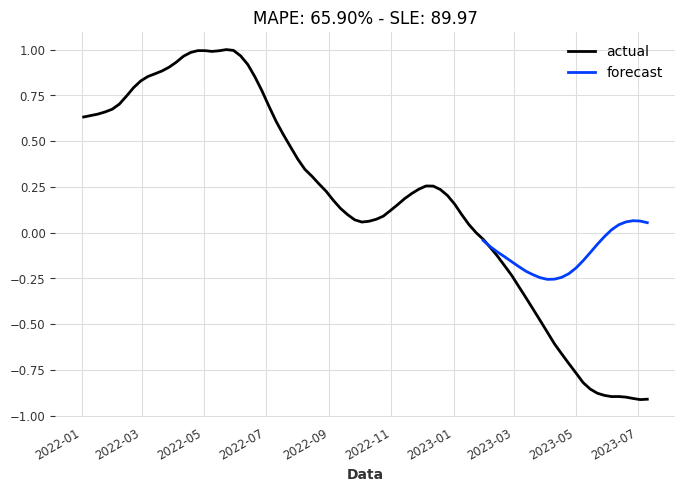

p: 28, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


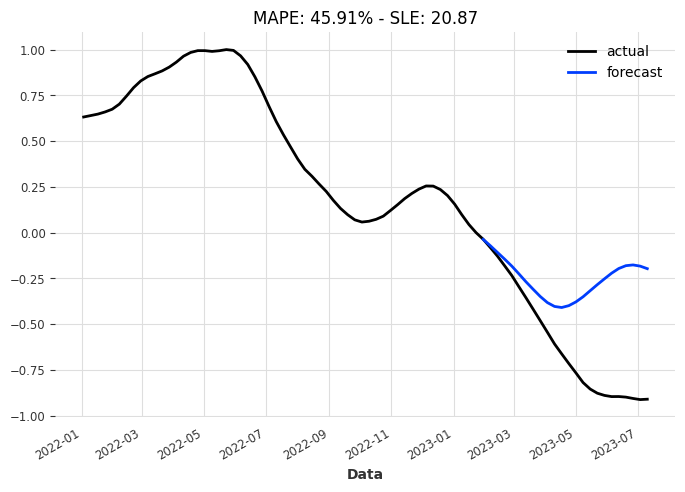

In [ ]:
for p in range(12, 30, 4):
  for d in range(1,3):
    print("p: {}, d: {}".format(p,d))

    model_arima = ARIMA(p, d)
    model_arima.fit(train_filtered_scaled)

    eval_model(model_arima, len(val_filtered_scaled), series_national_filtered_scaled, val_filtered_scaled)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


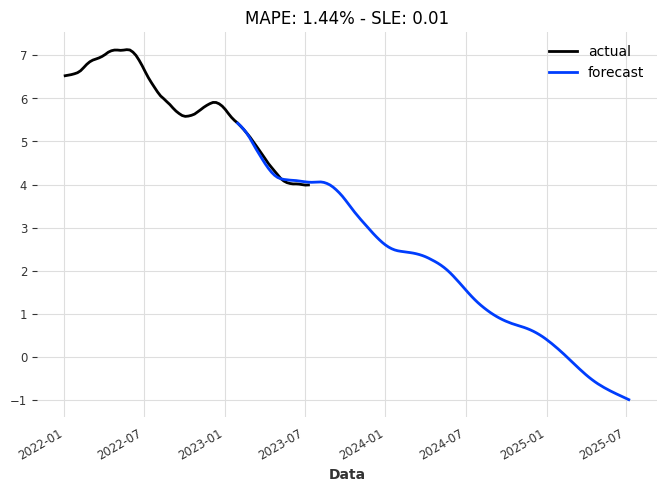

[]

In [ ]:
## Melhor modelo

model_arima = ARIMA(20, 2)
model_arima.fit(train_filtered_scaled)

eval_model(model_arima, len(val_filtered) + 365*2//7, series_national_filtered, val_filtered, train_filtered_scaled, train_filtered)

## Usando o ARIMA na série filtrada e sem tendência

p: 12, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


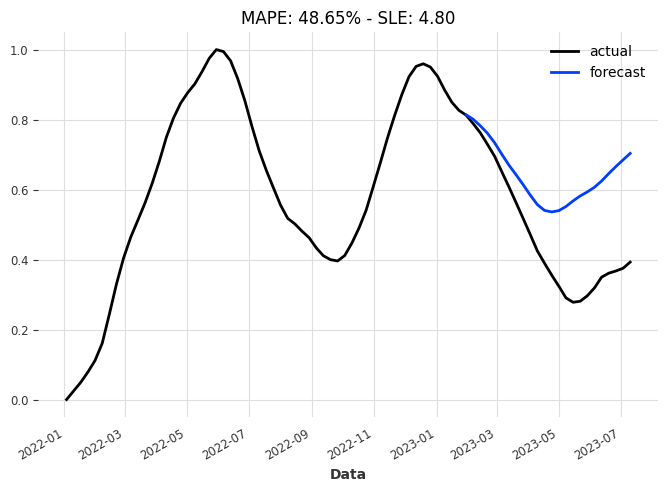

p: 12, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


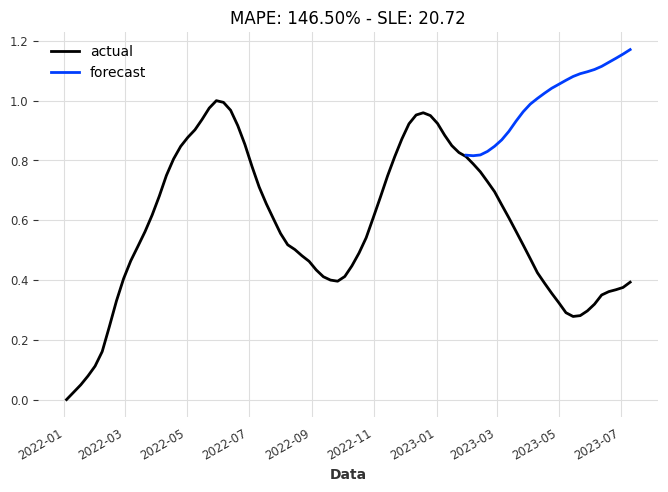

p: 16, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


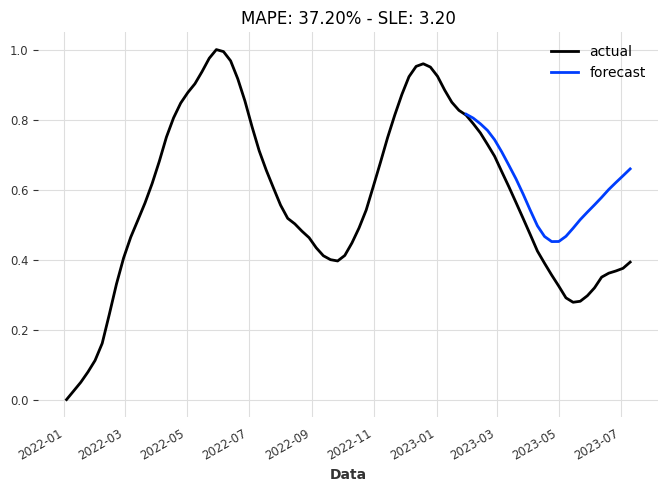

p: 16, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


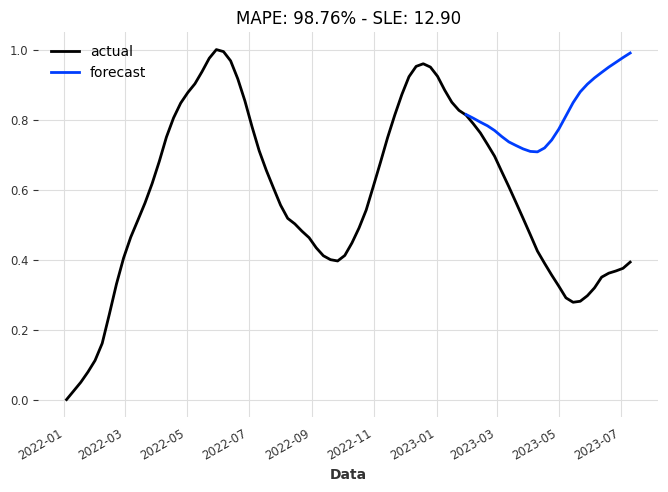

p: 20, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


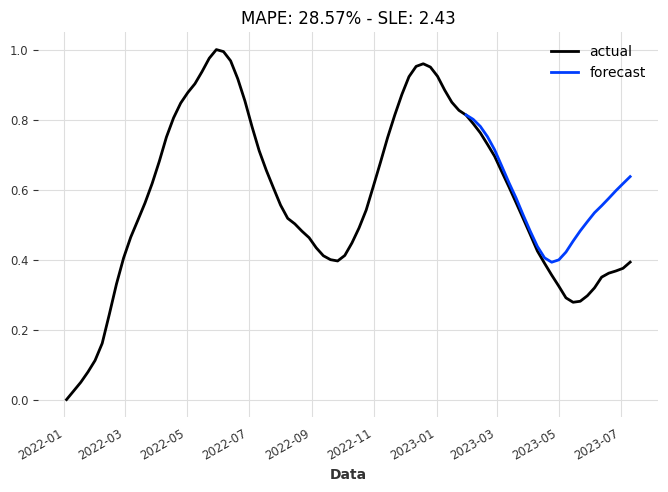

p: 20, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


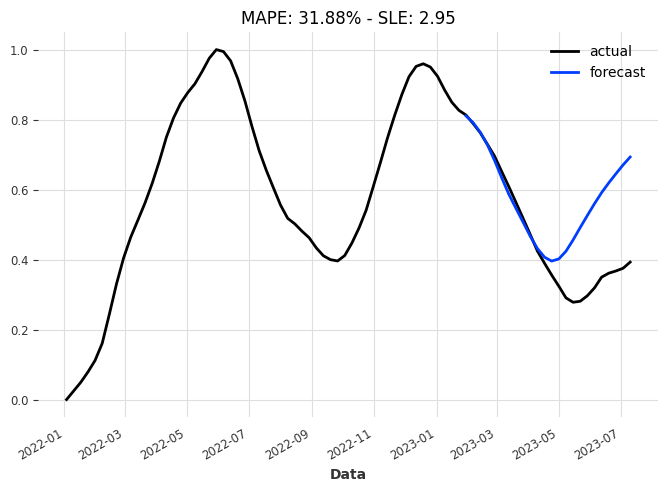

p: 24, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


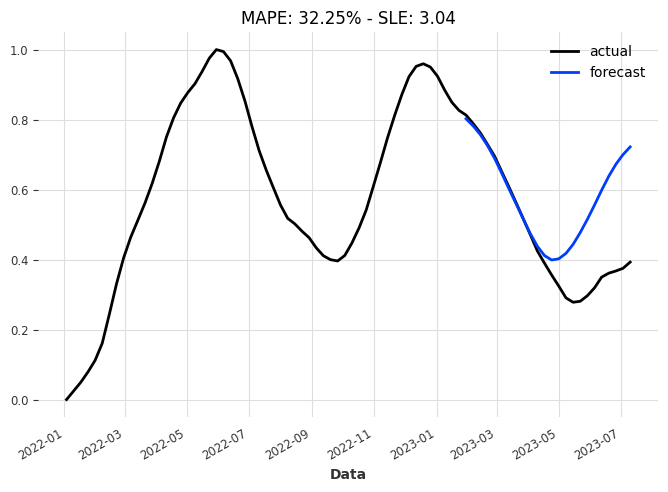

p: 24, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


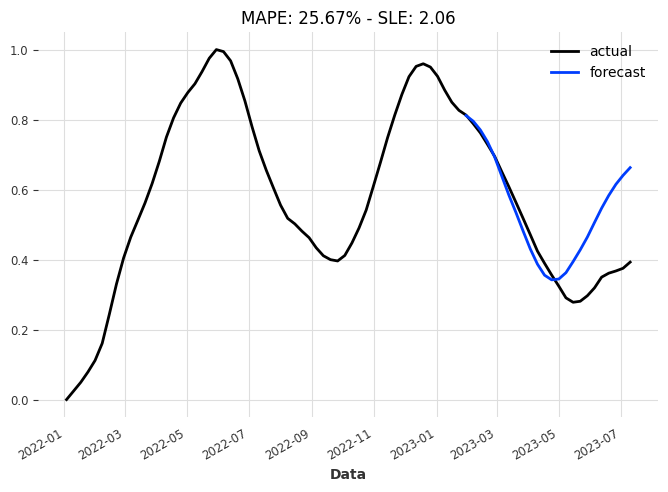

p: 28, d: 1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


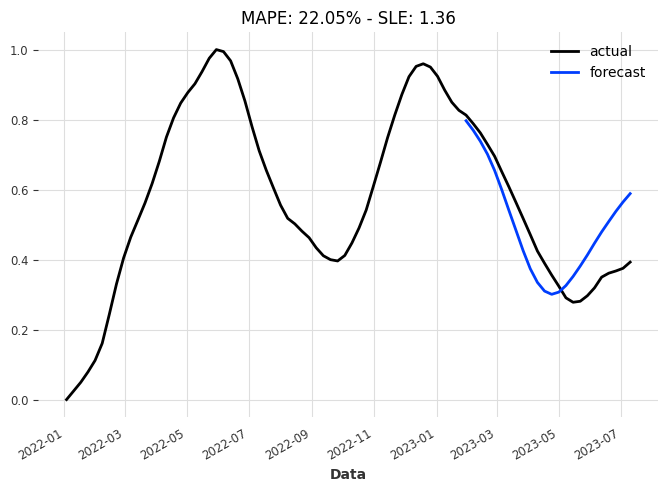

p: 28, d: 2


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


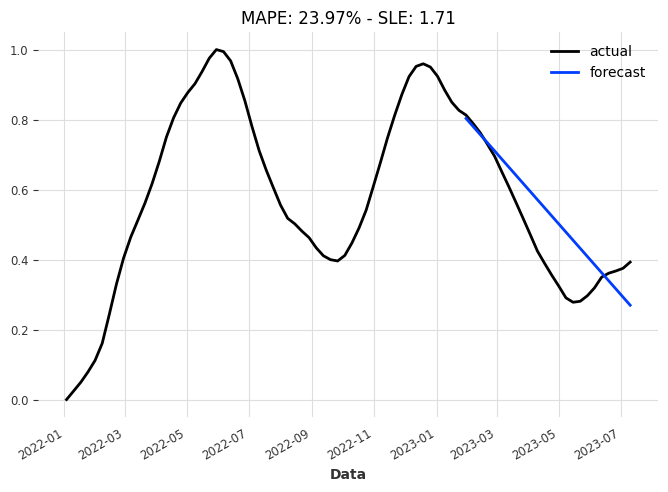

In [ ]:
for p in range(12, 30, 4):
  for d in range(1,3):
    print("p: {}, d: {}".format(p,d))

    model_arima = ARIMA(p, d)
    model_arima.fit(train_detrend_filtered_scaled)

    eval_model(model_arima, len(val_detrend_filtered_scaled), series_national_detrend_filtered_scaled, val_detrend_filtered_scaled)

p: 0, d: 0, q: 0, s: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


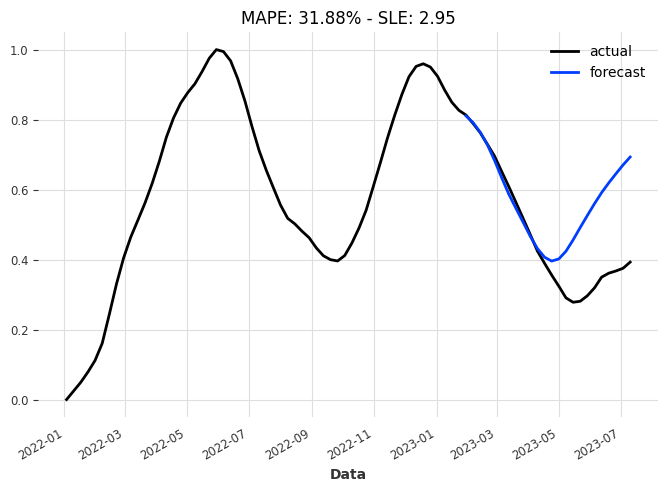

p: 0, d: 0, q: 0, s: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


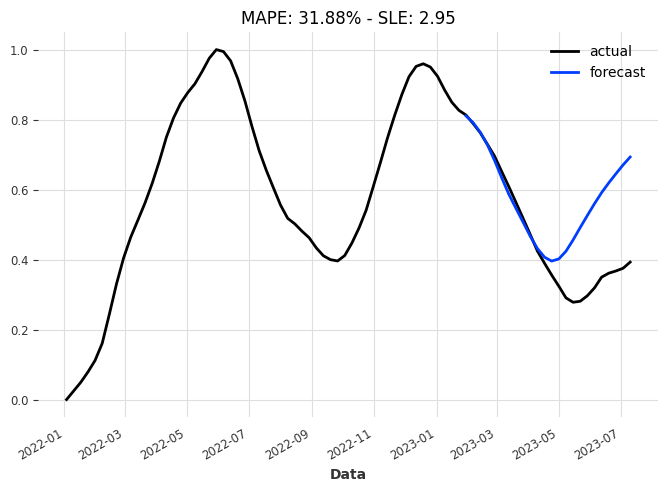

p: 0, d: 0, q: 2, s: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


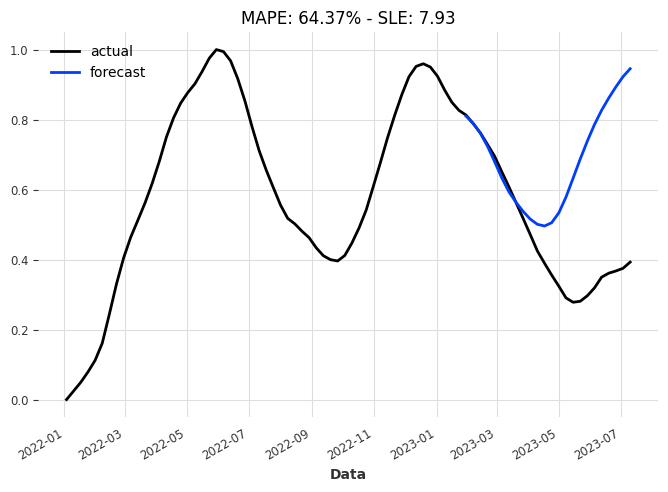

p: 0, d: 0, q: 2, s: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


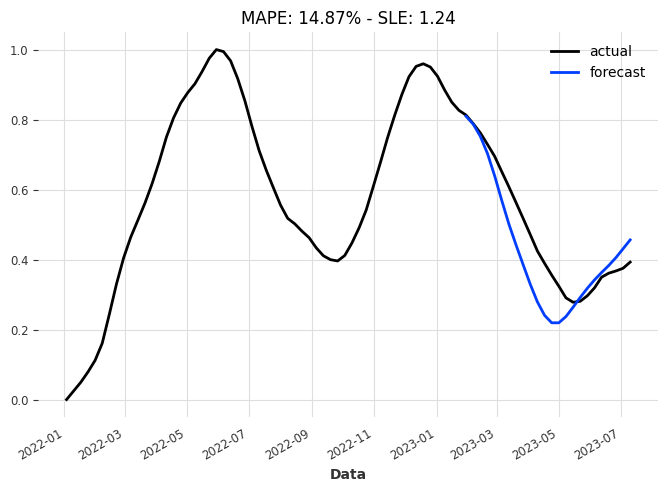

p: 0, d: 0, q: 4, s: 20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


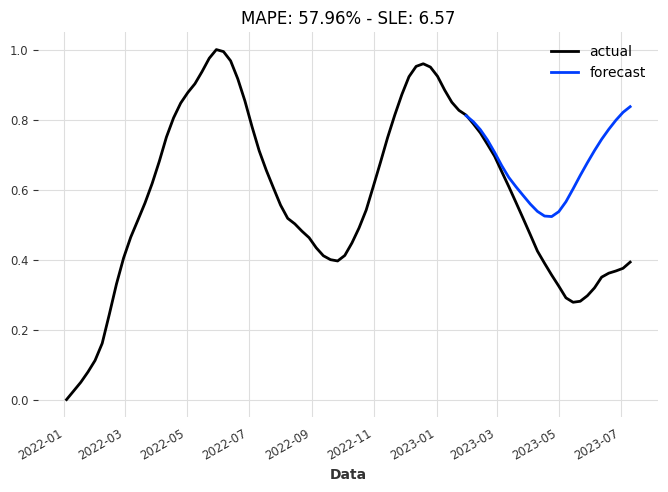

p: 0, d: 0, q: 4, s: 25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


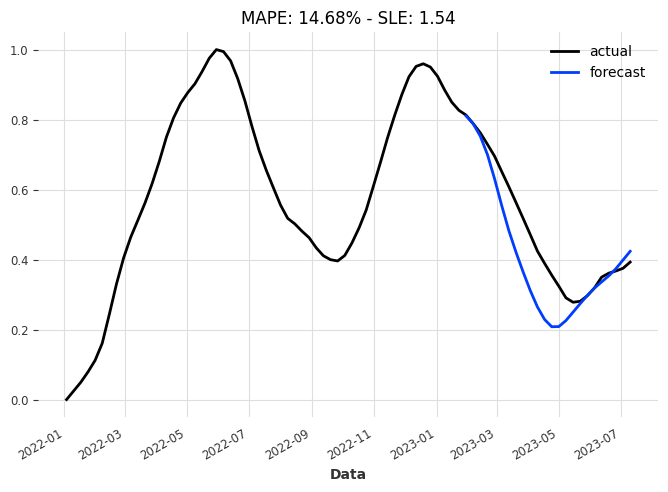

In [ ]:
for p in [0]:
  for d in [0]:
    for q in range(0,5, 2):
      for s in range(20, 30, 5):
        print("p: {}, d: {}, q: {}, s: {}".format(p,d, q, s))

        model_arima = ARIMA(p = 20, d = 2, seasonal_order = (p,d,q,s))
        model_arima.fit(train_detrend_filtered_scaled)

        eval_model(model_arima, len(val_detrend_filtered_scaled), series_national_detrend_filtered_scaled, val_detrend_filtered_scaled)